In [1]:
# Цель исследования: узнать как количество работников в команде влияет на производительность.
# Предпологались такие прикладные задачи как дать первичный ориентир для дробления отделов и открытия филиалов.
# С помощью GPT сгенерированны ключивые слова для поиска датосетов: productivity dataset, team efficiency, lab productivity, nonprofit dataset и т.д.
# В ходе поиска отбирались датосеты где есть прямые или косвенные показатели количество людей в отделе и завершённой работы. Выписанно пару десятков.
# Дальнейшая проверка показала что часть данных оказалось синтетическим, описание недействительным, назначение неподходящим. Один датосет просто битый.

# В коде участвует 11 таблиц, из них 10 уникальных и один оказался дублем.
# 4 таблицы проанализированы, в остальных оказались нерелевантные данные. 1 из этих 4 оказалась синтетической и была отброшена.
# В конечном счёте в анализе приняли участия таблицы по французским исследователям, американским НКО и полиции.

# По теме есть нехватка коммерческим данным, так как большинство их них синтетические. 
# Остальные источники не содержат стыкующихся записей о количестве сотрудников на разных предприятиях, прямых или косвенных показателей эффективности.
# Ещё на предварительном этапе отсеял пару десятков таблиц на kaggle и сомневаюсь что можно было отыскать значительно больше данных по теме.

In [76]:
!pip install duckdb
!pip install polars
import duckdb as db
import matplotlib.pyplot as plt
import polars as pl
import re

In [3]:
# Создаём базу в sql, чтобы всё время не писать 'Extended_Employee_Performance_and_Productivity_Data.csv' (скобки'',.csv и длинноке название )
db.sql(f"""
CREATE OR REPLACE TEMP TABLE commercial AS
SELECT *
FROM 'Extended_Employee_Performance_and_Productivity_Data.csv'
""")

# Смотрим что внутри
db.sql("""
SELECT *
FROM commercial
LIMIT 10
""").df()

Employee_ID        Department  Gender  Age   Job_Title  \
0            1                IT    Male   55  Specialist   
1            2           Finance    Male   29   Developer   
2            3           Finance    Male   55  Specialist   
3            4  Customer Support  Female   48     Analyst   
4            5       Engineering  Female   36     Analyst   
5            6                IT    Male   43     Manager   
6            7                IT    Male   37  Technician   
7            8       Engineering  Female   55    Engineer   
8            9         Marketing  Female   55  Technician   
9           10       Engineering  Female   45  Consultant   

                   Hire_Date  Years_At_Company Education_Level  \
0 2022-01-19 08:03:05.556036                 2     High School   
1 2024-04-18 08:03:05.556036                 0     High School   
2 2015-10-26 08:03:05.556036                 8     High School   
3 2016-10-22 08:03:05.556036                 7        Bachelor   
4 2021-07-23 08:03:05.556036                 3        Bachelor   
5 2016-08-14 08:03:05.556036                 8     High School   
6 2023-08-28 08:03:05.556036                 1        Bachelor   
7 2014-10-27 08:03:05.556036                 9        Bachelor   
8 2023-06-29 08:03:05.556036                 1     High School   
9 2016-12-23 08:03:05.556036                 7        Bachelor   

   Performance_Score  Monthly_Salary  Work_Hours_Per_Week  Projects_Handled  \
0                  5          6750.0                   33                32   
1                  5          7500.0                   34                34   
2                  3          5850.0                   37                27   
3                  2          4800.0                   52                10   
4                  2          4800.0                   38                11   
5                  3          7800.0                   46                31   
6                  5          5250.0                   55                20   
7                  2          7200.0                   42                46   
8                  2          4200.0                   51                23   
9                  1          6050.0                   41                33   

   Overtime_Hours  Sick_Days  Remote_Work_Frequency  Team_Size  \
0              22          2                      0         14   
1              13         14                    100         12   
2               6          3                     50         10   
3              28         12                    100         10   
4              29         13                    100         15   
5               8          0                    100         15   
6              29          2                      0         16   
7               7          8                    100          7   
8              21         14                      0          1   
9               2          6                     75          4   

   Training_Hours  Promotions  Employee_Satisfaction_Score  Resigned  
0              66           0                         2.63     False  
1              61           2                         1.72     False  
2               1           0                         3.17     False  
3               0           1                         1.86     False  
4               9           1                         1.25     False  
5              95           0                         2.77     False  
6              27           0                         4.46     False  
7              64           0                         2.09     False  
8               0           1                         1.44     False  
9              53           2                         2.93     False

In [4]:
# Начнём с того есть ли специфика между отраслями, для этого возьмём значения для каждой профессии в "департаменте"
db.sql("SELECT DISTINCT Department FROM commercial")

┌──────────────────┐
│    Department    │
│     varchar      │
├──────────────────┤
│ Legal            │
│ Finance          │
│ Customer Support │
│ Operations       │
│ HR               │
│ IT               │
│ Marketing        │
│ Engineering      │
│ Sales            │
└──────────────────┘

In [5]:
db.sql("SELECT DISTINCT Job_Title FROM commercial")

┌────────────┐
│ Job_Title  │
│  varchar   │
├────────────┤
│ Developer  │
│ Technician │
│ Analyst    │
│ Specialist │
│ Manager    │
│ Consultant │
│ Engineer   │
└────────────┘

In [6]:
# Переводим данные в формат для графика
df_plot = db.sql("""
SELECT
    Department,
    Job_Title,
    Projects_Handled,
    Team_Size
FROM commercial
WHERE
    Projects_Handled IS NOT NULL
    AND Team_Size IS NOT NULL
""").df()

In [7]:
#for dept in df_plot["Department"].unique():
    #sub = df_plot[df_plot["Department"] == dept]

    #plt.figure(figsize=(8, 5))

    #for job in sub["Job_Title"].unique():
     #   job_data = sub[sub["Job_Title"] == job]
      #  plt.plot(
       #     job_data["Projects_Handled"],
        #    job_data["Team_Size"],
         #   marker='o',
          #  label=job
        #)

    #plt.title(f"Department: {dept}")
    #plt.xlabel("Projects Handled")
    #plt.ylabel("Team Size")
    #plt.legend()
    #plt.grid(True)
    #plt.show()
# Попытка линейного графика оказалась неинформативной:
# данные не упорядочены во времени, линии создают визуальный шум

In [8]:
summary = db.sql("""
SELECT
    Department,
    Job_Title,
    Team_Size,
    COUNT(*) AS n_obs,
    AVG(Projects_Handled) AS avg_projects,
    MEDIAN(Projects_Handled) AS med_projects
FROM commercial
WHERE Team_Size > 0
GROUP BY Department, Job_Title, Team_Size
ORDER BY Department, Job_Title, Team_Size
""").df()
summary.head(10)

Department Job_Title  Team_Size  n_obs  avg_projects  med_projects
0  Customer Support   Analyst          1     98     23.663265          21.5
1  Customer Support   Analyst          2     73     25.260274          26.0
2  Customer Support   Analyst          3     92     23.804348          20.0
3  Customer Support   Analyst          4     92     25.000000          23.5
4  Customer Support   Analyst          5     77     24.922078          26.0
5  Customer Support   Analyst          6     93     24.537634          25.0
6  Customer Support   Analyst          7     72     21.902778          20.5
7  Customer Support   Analyst          8     88     24.579545          25.0
8  Customer Support   Analyst          9     67     25.626866          24.0
9  Customer Support   Analyst         10     80     25.500000          25.5

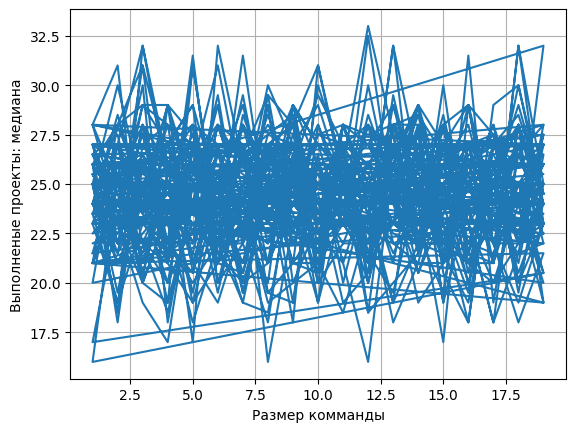

In [9]:
# Кажется, что цифры в одном диапозоне вне зависимости от размера команд. Посмотрим, проглядывается вообще какая-нибудь зависимость.
plt.plot(summary['Team_Size'], summary['med_projects'])
plt.xlabel('Размер комманды')
plt.ylabel('Выполненые проекты: медиана')
plt.grid(True)
plt.show()

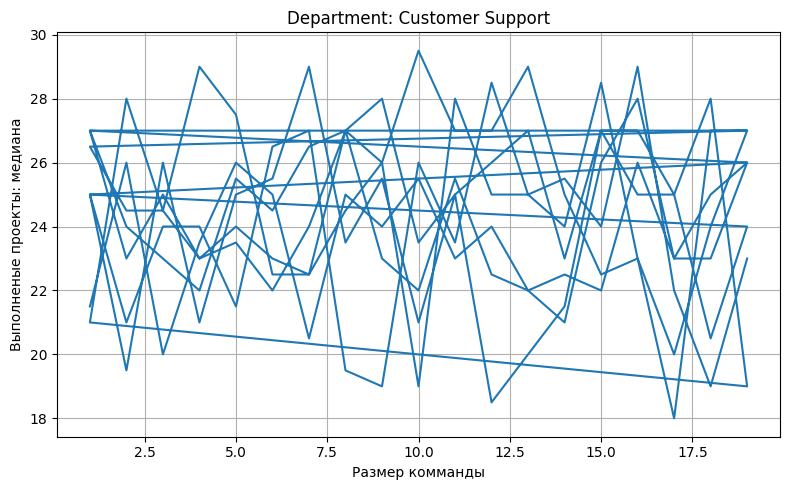

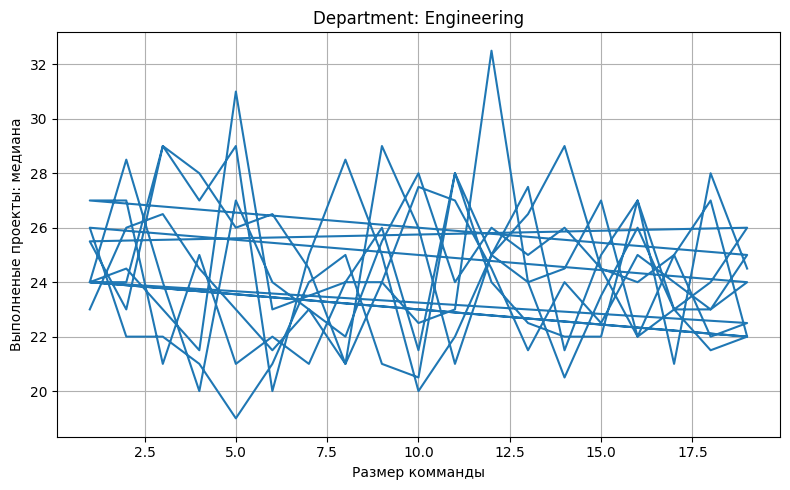

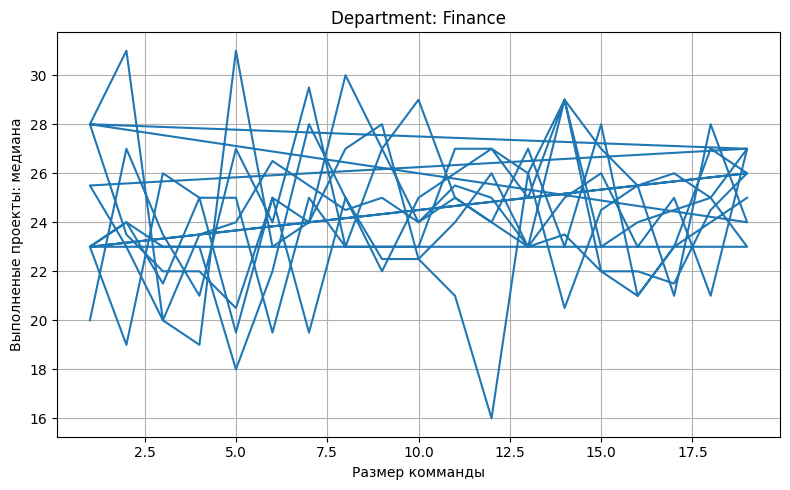

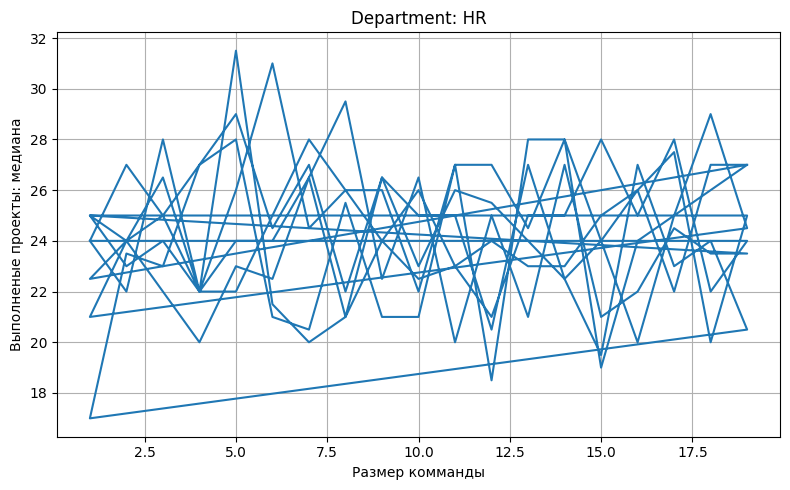

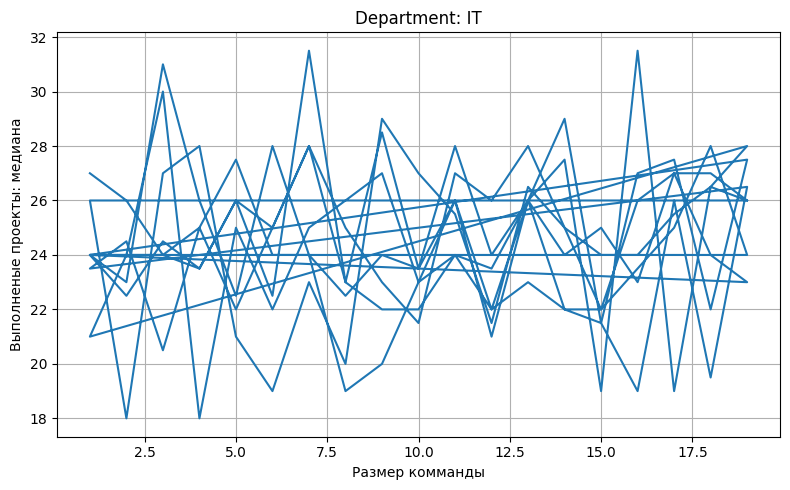

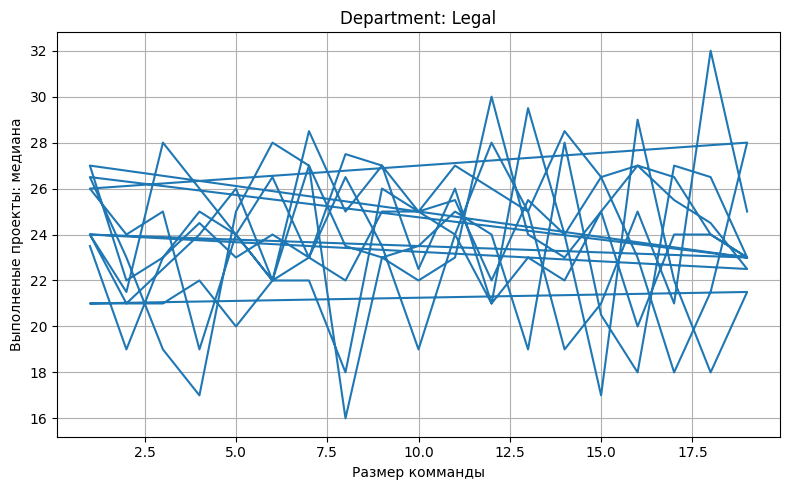

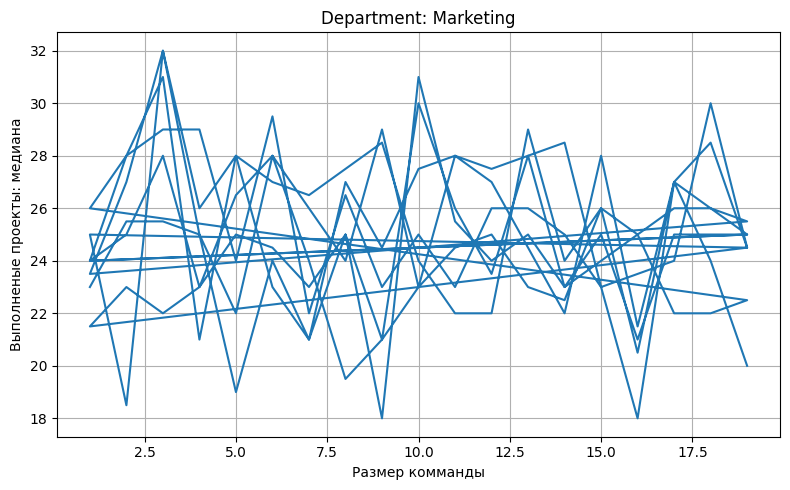

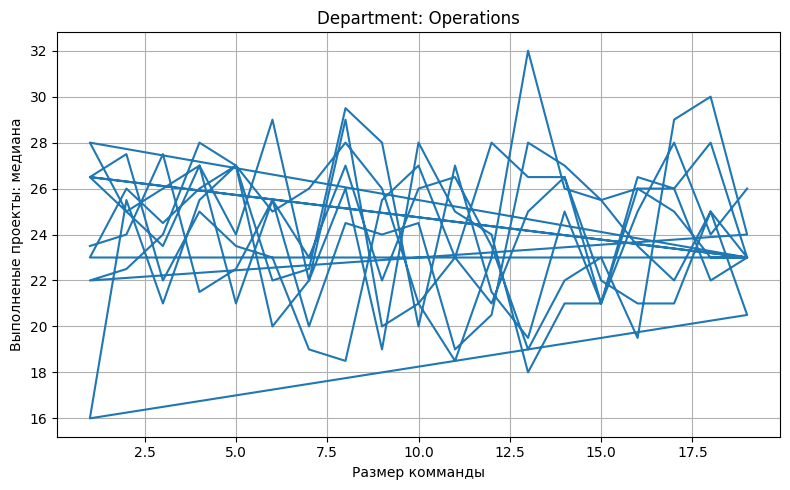

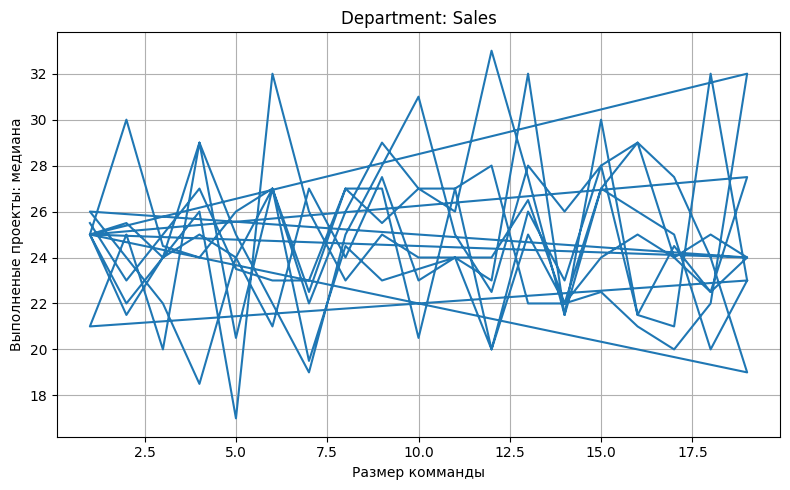

In [10]:
# Похоже, возможно и есть некая зависимость. Может шум вносят различия в депортаментах. Проверим.
for dept in summary["Department"].unique():
    sub = summary[summary["Department"] == dept]
    plt.figure(figsize=(8, 5))
    plt.plot(sub['Team_Size'], sub['med_projects'])
    plt.title(f"Department: {dept}")
    plt.xlabel('Размер комманды')
    plt.ylabel('Выполненые проекты: медиана')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

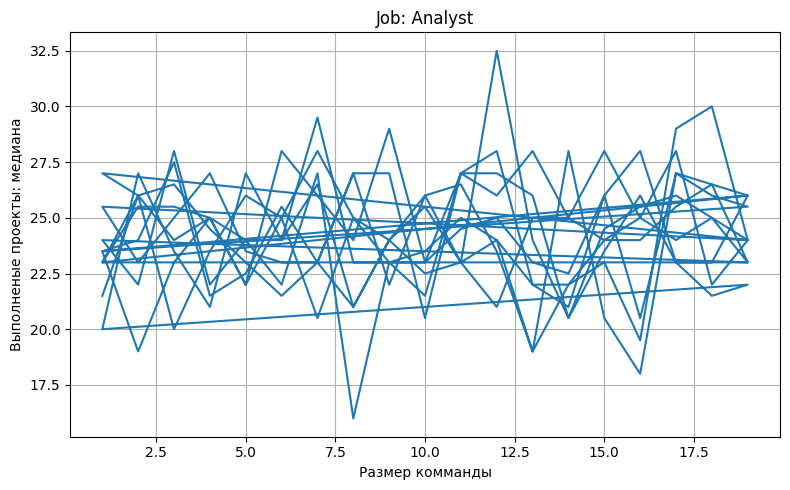

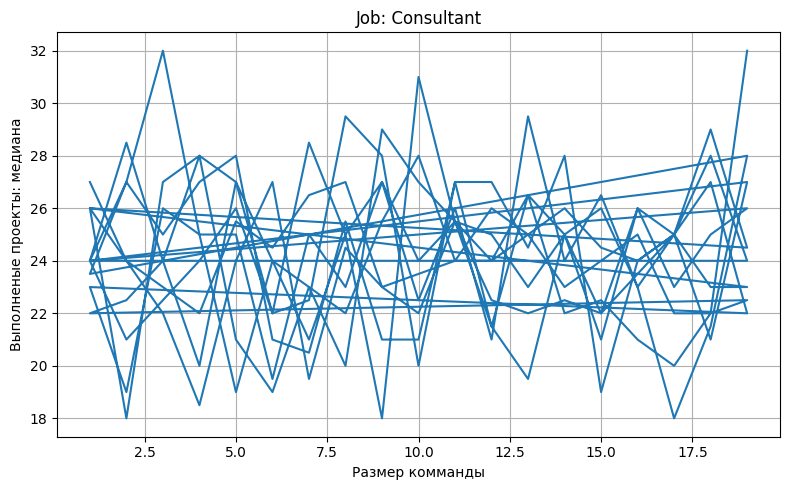

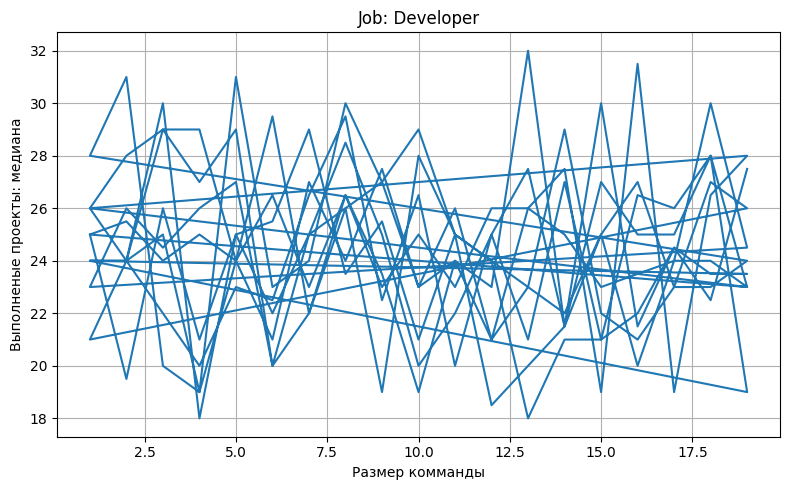

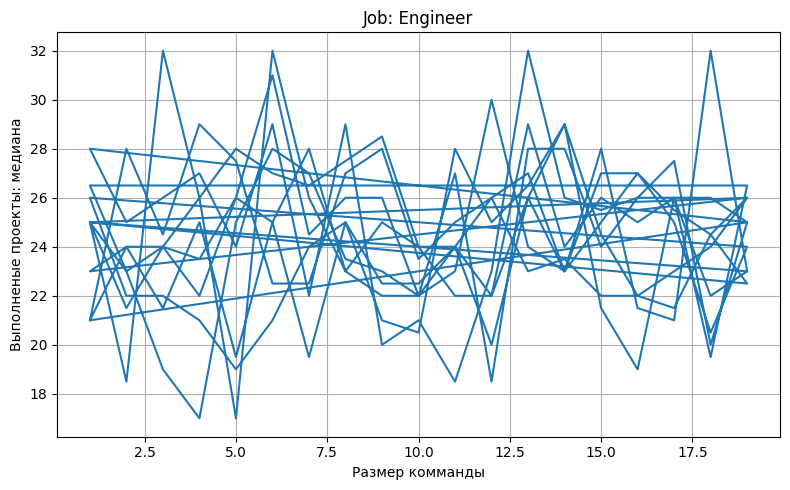

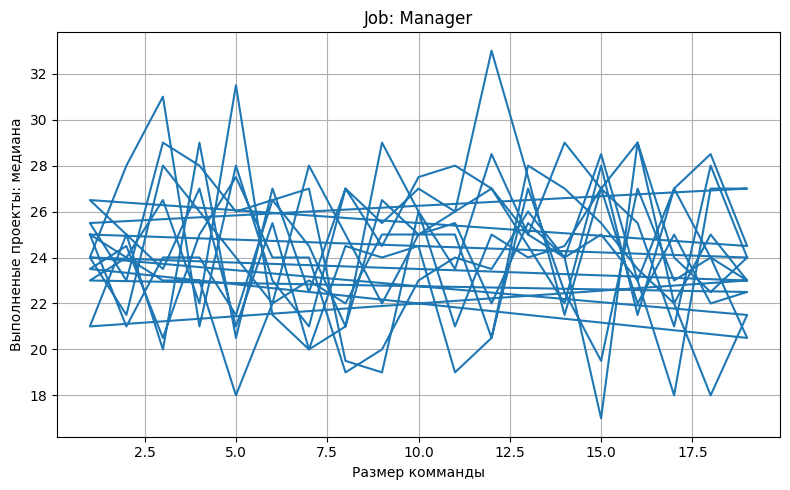

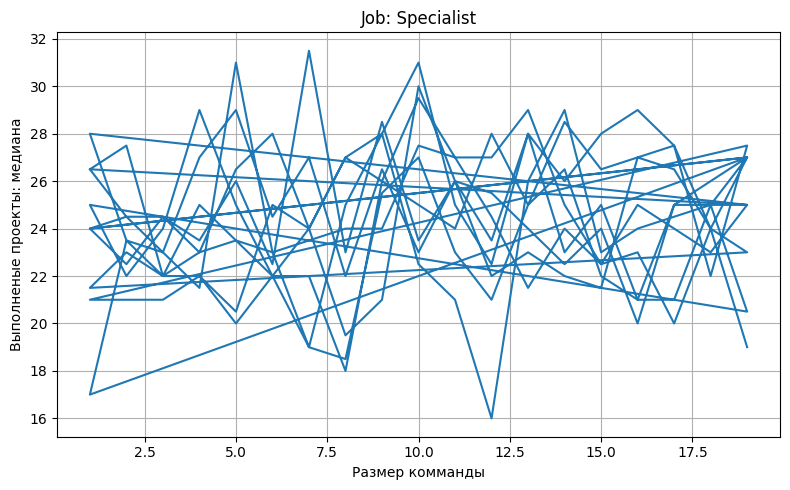

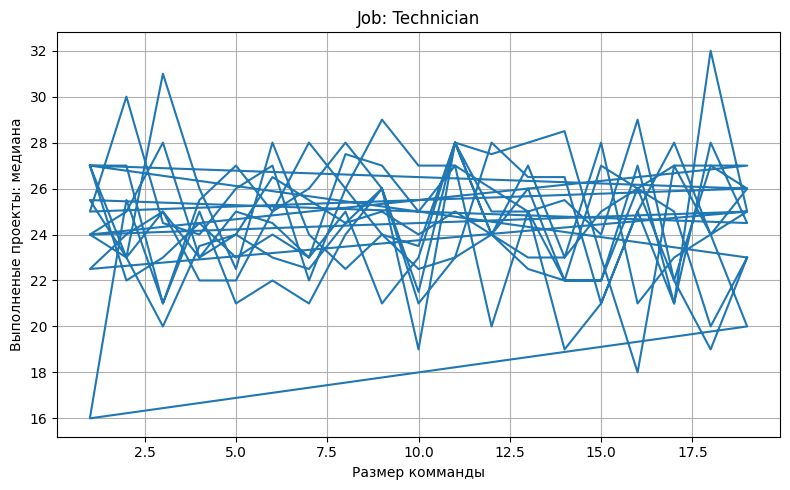

In [11]:
# Возможно и есть некая зависимость. Может шум вносят различия в работах. Посмотрим, может что-то от фильтровать.
for job in summary["Job_Title"].unique():
    sub = summary[summary["Job_Title"] == job]
    plt.figure(figsize=(8, 5))
    plt.plot(sub['Team_Size'], sub['med_projects'])
    plt.title(f"Job: {job}")
    plt.xlabel('Размер комманды')
    plt.ylabel('Выполненые проекты: медиана')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

  Education_Level  Team_Size  n_obs  avg_projects  med_projects
0        Bachelor          1   2609     24.291683          24.0
1        Bachelor          2   2621     23.992751          24.0
2        Bachelor          3   2672     24.645958          25.0
3        Bachelor          4   2642     24.389478          25.0
4        Bachelor          5   2651     24.304791          25.0
5        Bachelor          6   2549     24.489604          24.0
6        Bachelor          7   2583     24.473480          24.0
7        Bachelor          8   2583     24.570654          25.0
8        Bachelor          9   2630     24.414449          25.0
9        Bachelor         10   2643     24.397276          24.0


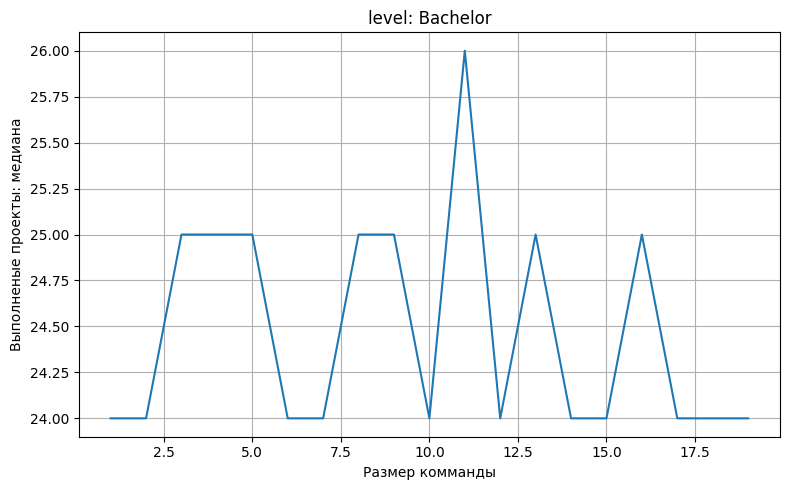

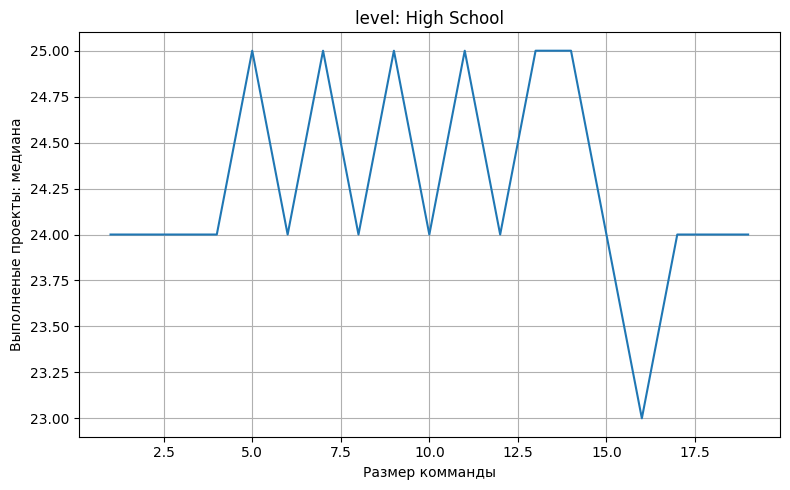

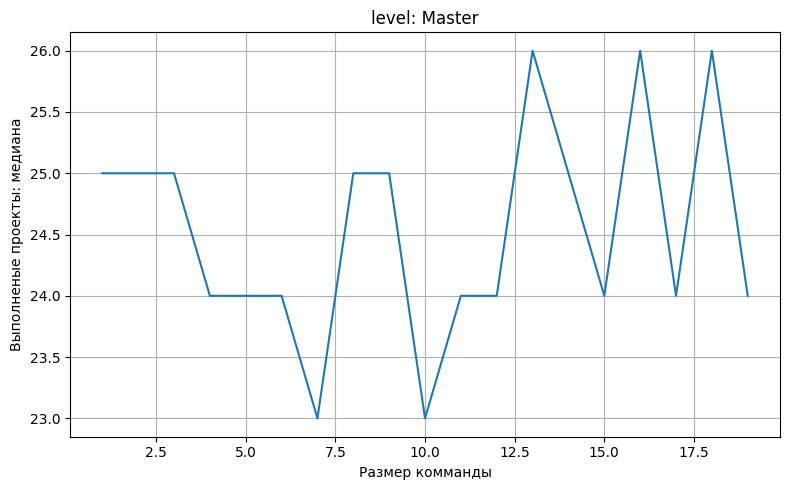

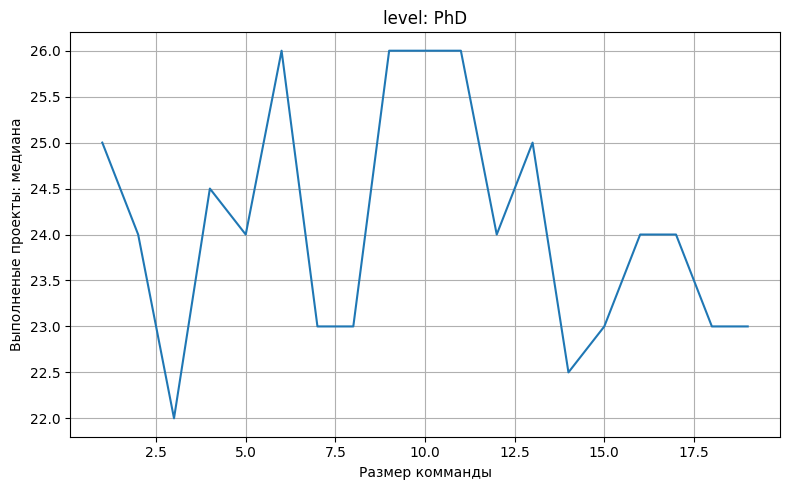

In [12]:
# Вдруг есть более явная зависимость в уровнях образования

summary_edu = db.sql("""
SELECT
    Education_Level,
    Team_Size,
    COUNT(*) AS n_obs,
    AVG(Projects_Handled) AS avg_projects,
    MEDIAN(Projects_Handled) AS med_projects
FROM commercial
WHERE Team_Size > 0
GROUP BY Education_Level, Team_Size
ORDER BY Education_Level, Team_Size
""").df()
print(summary_edu.head(10))

for level in summary_edu["Education_Level"].unique():
    sub = summary_edu[summary_edu["Education_Level"] == level]
    plt.figure(figsize=(8, 5))
    plt.plot(sub['Team_Size'], sub['med_projects'])
    plt.title(f"level: {level}")
    plt.xlabel('Размер комманды')
    plt.ylabel('Выполненые проекты: медиана')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [13]:
# Можно попытаться отследить закономерности, однако разница между медианами нестабильно и будет всё равно в диапазоне около 4 из 25

In [14]:
# Думаю узнать какой процент в summary занимает каждый условный unique, чтобы возможно отфильтровать часть данных как не типовой случай
summary_year_in_comp = db.sql("""
SELECT
    Years_At_Company
FROM commercial
""").df()

years_share = (
    summary_year_in_comp['Years_At_Company']
    .value_counts(dropna=False, normalize=True)
    .mul(100)
    .reset_index()
)
print(years_share)

    Years_At_Company  proportion
0                  2      10.272
1                  4      10.103
2                  0      10.083
3                  6      10.068
4                  1      10.018
5                  8       9.961
6                  3       9.935
7                  7       9.892
8                  5       9.892
9                  9       9.732
10                10       0.044


In [15]:
# Переменная Years_At_Company имеет близкое к равномерному распределение, 
# что указывает на вероятно синтетический или категориально агрегированный характер данных.
# Поэтому, выводы стоит перепроверить по другим датосетам.

# Оставшиеся метрики в текущем датасете включают показатели с неясной методологией
# (оценка эффективности, удовлетворённость сотрудников и др.), а также слабо динамичные
# переменные (часы обучения, отдельные HR-показатели).

# Вероятно, они не дадут достаточно устойчивых и интерпретируемых результатов
# для первичной ориентировки и обобщённых выводов.

# В связи с этим целесообразно перейти к анализу другого датасета
# с более широким охватом организационных и операционных показателей.

# К данному набору данных можно вернуться позднее —
# либо для сопоставления результатов, либо для более детального анализа
# в случае необходимости подтвердить слабость выявленных зависимостей.

In [16]:
# На странице Kaggle три файла: people-data, archivedata, и archive-cargo-data. Названия неоднозначны, посмотрим во всех
# При загрузке people-data.csv обнаружена ошибка кодировки: файл не соответствует UTF-8 и header = false
# Файл содержит ошибки кодировки и структуры строк, поэтому был загружен в режиме с ослабленной валидацией (ignore_errors, all_varchar).

db.sql("""
CREATE OR REPLACE TEMP TABLE people AS
SELECT *
FROM read_csv_auto(
    'people-data.csv',
    ignore_errors=true,
    all_varchar=true
)
""")

db.sql("SELECT * FROM people LIMIT 10").df()

column0       column1       column2                         column3  \
0   10901      'Mahika'        'Char'         'mahika.char@gmail.com'   
1   10901    'Theodore'       'Patil'      'theodore.patil@gmail.com'   
2   10901    'Vasatika'          'Om'         'vasatika.om@gmail.com'   
3   10901       'Omaja'   'Varughese'     'omaja.varughese@yahoo.com'   
4   10901       'Sanya'     'Prakash'     'sanya.prakash@hotmail.com'   
5   10901       'Zarna'     'Mahajan'       'zarna.mahajan@gmail.com'   
6   10901     'Banjeet'   'Chaudhary'   'banjeet.chaudhary@gmail.com'   
7   10901     'Patrick'      'Narain'    'patrick.narain@hotmail.com'   
8   10901        'Osha'       'Dugal'        'osha.dugal@hotmail.com'   
9   10901   'Chaitanya'        'Buch'      'chaitanya.buch@gmail.com'   

                               column4 column5 column6  \
0   '32250170a0dca92d53ec9624f336ca24'    None       2   
1   '32250170a0dca92d53ec9624f336ca24'    None       3   
2   '32250170a0dca92d53ec9624f336ca24'    None       4   
3   '32250170a0dca92d53ec9624f336ca24'    None       5   
4   '32250170a0dca92d53ec9624f336ca24'    None       6   
5   '32250170a0dca92d53ec9624f336ca24'    None       7   
6   '32250170a0dca92d53ec9624f336ca24'    None       8   
7   '32250170a0dca92d53ec9624f336ca24'    None       9   
8   '32250170a0dca92d53ec9624f336ca24'    None      10   
9   '32250170a0dca92d53ec9624f336ca24'    None      11   

                   column7  
0   '2022-04-07 00:57:45')  
1   '2020-05-11 23:21:40')  
2   '2018-10-31 14:59:45')  
3   '2018-09-09 11:11:50')  
4   '2022-07-02 11:10:21')  
5   '2019-07-03 13:19:15')  
6   '2018-05-05 17:35:11')  
7   '2021-02-22 22:38:07')  
8   '2021-01-31 17:34:06')  
9   '2022-04-19 22:57:54')

In [17]:
# Прошлый файл не содержал полезных для исследования метрик

# Исходный archivedata.csv открывался в Excel, но не читался стандартными CSV-парсерами из-за кодировки (UTF-16 / Excel Unicode) и неявного разделителя.
# Для обеспечения воспроизводимости пайплайна файл был пересохранён в UTF-8, а разделитель задан явно (delim=';').

db.sql("""
CREATE OR REPLACE TEMP TABLE archivedata AS
SELECT *
FROM read_csv_auto(
    'archivedata.csv',
    header=true,
    delim=';'
)
""")

db.sql("SELECT * FROM archivedata LIMIT 10").df()

sr_no  id_number   reference_number sender_name sender_address_line1  \
0  50043    2001223        Zaitra Vasa           4            Bumb Road   
1  50044    2001224    Jeremiah Shroff         272          Sarkar Zila   
2  50045    2001225         Kala Varty      13/034           Guha Nagar   
3  50046    2001226         Sanya Mand       74/29          Kata Circle   
4  50047    2001227            Yug Lad   H.No. 231           Batta Path   
5  50048    2001228     Sanaya Purohit          42          Lalla Chowk   
6  50049    2001229   Nikita Prabhakar         413           Vohra Ganj   
7  50050    2001230         Radha Dyal    H.No. 26         Khosla Nagar   
8  50051    2001231     Utkarsh Mitter         327           Iyer Chowk   
9  50052    2001232      Henry Shanker    H.No. 31   Padmanabhan Circle   

           sender_address_line2 sender_address_line3    sender_contact  \
0   Kirari Suleman Nagar 150552       +91 8127108512    Gayathri Verma   
1              Faridabad-941269       +91 8046752709     Anya Nadkarni   
2             Pallavaram 450672       +91 9630638367        Wahab Dash   
3             Aurangabad-255209       +91 8772650869   Pallavi Prashad   
4                 Tenali 610535       +91 8549247626         Yash Tank   
5               Varanasi-121219       +91 9867894567    Yamini Goswami   
6                   Guna 814361       +91 7761900597      Oviya Shenoy   
7                 Nashik-912071       +91 6847669657      Harish Walla   
8                   Durg 774632       +91 8607430215     Jeremiah Jani   
9                  Anand-184021       +91 7417415656     Henry Pradhan   

  recipient_name recipient_address_line1  ... recipient_address_line3  \
0          38/15              Misra Ganj  ...          +91 8107696243   
1      H.No. 510            Mitter Nagar  ...          +91 7136109915   
2            632              Balan Path  ...          +91 6694989822   
3       H.No. 65                    Mani  ...          +91 6189699444   
4       H.No. 34             Sarin Chowk  ...          +91 7651815027   
5      H.No. 979               Buch Marg  ...          +91 9449336336   
6          97/74             Butala Marg  ...          +91 9653043639   
7       H.No. 91           Kapadia Nagar  ...          +91 7506078500   
8      H.No. 192               Kata Marg  ...          +91 8825523396   
9             98          Ramaswamy Road  ...          +91 7376773008   

  recipient_contact estimated_days  from_branch_id  to_branch_id  \
0                 2             21              43          6300   
1                 1             34             119           234   
2                 1              7              95          2289   
3                 2             52              92          4146   
4                 2             34              72          2822   
5                 1             88               2          6029   
6                 1            123             139          3712   
7                 2             54             135          3309   
8                 1             21              73           395   
9                 2             90             130          1958   

                  price date_and_time  \
0   2022-07-06 21:15:48     delivered   
1   2022-07-06 21:13:54     delivered   
2   2022-07-06 08:48:21     delivered   
3   2022-07-06 06:40:31     delivered   
4   2022-07-06 04:36:40     delivered   
5   2022-07-06 01:39:12     delivered   
6   2022-07-06 00:44:44     delivered   
7   2022-07-05 21:53:55     delivered   
8   2022-07-05 05:07:24     delivered   
9   2022-07-04 19:33:37     delivered   

                                     delivery_status transporter column20  
0     Blue Line Cargo & Logistics - New Delhi, Delhi        None     None  
1     Blue Line Cargo & Logistics - New Delhi, Delhi        None     None  
2     Blue Line Cargo & Logistics - New Delhi, Delhi        None     None  
3  Global Express Logistics Pvt. Ltd. - Bengaluru... 

In [18]:
# Смотрим все названия колонок
db.sql("DESCRIBE archivedata")

┌─────────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│       column_name       │ column_type │  null   │   key   │ default │  extra  │
│         varchar         │   varchar   │ varchar │ varchar │ varchar │ varchar │
├─────────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ sr_no                   │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ id_number               │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ reference_number        │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ sender_name             │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ sender_address_line1    │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ sender_address_line2    │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ sender_address_line3    │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ sender_contact          │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ recipient_name

In [19]:
# Придётся просматривать каждую колонку вручную. Можно исключить просто по категориям вроде id и address, но в
# "delivery_status" на самом деле стоит название компании и если я не найду название профессии, оно единственное по чему я могу отличать данные 
db.sql("SELECT column20 FROM archivedata WHERE column20 IS NOT NULL LIMIT 10;") # если не ставить "WHERE 0 IS NOT NULL" выдаст только строки с NULL

┌───────────────────────────────────────────────────────┐
│                       column20                        │
│                        varchar                        │
├───────────────────────────────────────────────────────┤
│ Rapid Delivery & Cargo Solutions - Ahmedabad, Gujarat │
│ Rapid Delivery & Cargo Solutions - Ahmedabad, Gujarat │
│ Rapid Delivery & Cargo Solutions - Ahmedabad, Gujarat │
│ Rapid Delivery & Cargo Solutions - Ahmedabad, Gujarat │
└───────────────────────────────────────────────────────┘

In [20]:
db.sql("SELECT transporter FROM archivedata WHERE transporter IS NOT NULL LIMIT 10;")

┌────────────────────────────────────────────────┐
│                  transporter                   │
│                    varchar                     │
├────────────────────────────────────────────────┤
│ Blue Line Cargo & Logistics - New Delhi, Delhi │
│ Blue Line Cargo & Logistics - New Delhi, Delhi │
│ Blue Line Cargo & Logistics - New Delhi, Delhi │
│ Blue Line Cargo & Logistics - New Delhi, Delhi │
│ Blue Line Cargo & Logistics - New Delhi, Delhi │
│ Blue Line Cargo & Logistics - New Delhi, Delhi │
│ Blue Line Cargo & Logistics - New Delhi, Delhi │
│ Blue Line Cargo & Logistics - New Delhi, Delhi │
│ Blue Line Cargo & Logistics - New Delhi, Delhi │
│ Blue Line Cargo & Logistics - New Delhi, Delhi │
├────────────────────────────────────────────────┤
│                    10 rows                     │
└────────────────────────────────────────────────┘

In [21]:
db.sql("SELECT recipient_address_line2 FROM archivedata WHERE recipient_address_line2 IS NOT NULL LIMIT 10;")

┌──────────────────────────────────────┐
│       recipient_address_line2        │
│               varchar                │
├──────────────────────────────────────┤
│  Alappuzha 088508                    │
│  Bikaner-147633                      │
│  Jaipur 308817                       │
│  Berhampur-390597                    │
│  Ajmer-500279                        │
│  Jamalpur-083335                     │
│  Tezpur-557841                       │
│  Bhopal 011155                       │
│  Meerut-048051                       │
│  Raurkela Industrial Township 993761 │
├──────────────────────────────────────┤
│               10 rows                │
└──────────────────────────────────────┘

In [22]:
# Взял несколько потенциально говорящих названий и посмотрел есть ли между ними связь.
# Однако даже если искать между ними закономерность, ей нельзя будет доверять, поэтому исключим этот датосет из исследования.
db.sql("SELECT estimated_days, from_branch_id, to_branch_id, price, date_and_time FROM archivedata LIMIT 10;")

┌────────────────┬────────────────┬──────────────┬──────────────────────┬───────────────┐
│ estimated_days │ from_branch_id │ to_branch_id │        price         │ date_and_time │
│     int64      │     int64      │    int64     │       varchar        │    varchar    │
├────────────────┼────────────────┼──────────────┼──────────────────────┼───────────────┤
│             21 │             43 │         6300 │  2022-07-06 21:15:48 │ delivered     │
│             34 │            119 │          234 │  2022-07-06 21:13:54 │ delivered     │
│              7 │             95 │         2289 │  2022-07-06 08:48:21 │ delivered     │
│             52 │             92 │         4146 │  2022-07-06 06:40:31 │ delivered     │
│             34 │             72 │         2822 │  2022-07-06 04:36:40 │ delivered     │
│             88 │              2 │         6029 │  2022-07-06 01:39:12 │ delivered     │
│            123 │            139 │         3712 │  2022-07-06 00:44:44 │ delivered     │
│         

In [23]:
# На всякий случай проверили другой файл. Пересохранили его как прошлый чтобы открыть. По размеру и содержанию на первый взгляд они индетичны.
# Скопировали результат запроса из этой таблицы и прошлой. Сайт онлайн сравнения текстов показал что тексты одинаковые. 

# Ошибка была из-за дефисов (-) в названии таблицы. Нужно брать в двойные кавычки
db.sql("""
CREATE OR REPLACE TEMP TABLE archive_cargo_data AS
SELECT *
FROM read_csv_auto(
    "archive-cargo-data.csv",
    header=true,
    delim=';'
)
""")

db.sql("SELECT * FROM archive_cargo_data LIMIT 10").df()

sr_no  id_number   reference_number sender_name sender_address_line1  \
0  50043    2001223        Zaitra Vasa           4            Bumb Road   
1  50044    2001224    Jeremiah Shroff         272          Sarkar Zila   
2  50045    2001225         Kala Varty      13/034           Guha Nagar   
3  50046    2001226         Sanya Mand       74/29          Kata Circle   
4  50047    2001227            Yug Lad   H.No. 231           Batta Path   
5  50048    2001228     Sanaya Purohit          42          Lalla Chowk   
6  50049    2001229   Nikita Prabhakar         413           Vohra Ganj   
7  50050    2001230         Radha Dyal    H.No. 26         Khosla Nagar   
8  50051    2001231     Utkarsh Mitter         327           Iyer Chowk   
9  50052    2001232      Henry Shanker    H.No. 31   Padmanabhan Circle   

           sender_address_line2 sender_address_line3    sender_contact  \
0   Kirari Suleman Nagar 150552       +91 8127108512    Gayathri Verma   
1              Faridabad-941269       +91 8046752709     Anya Nadkarni   
2             Pallavaram 450672       +91 9630638367        Wahab Dash   
3             Aurangabad-255209       +91 8772650869   Pallavi Prashad   
4                 Tenali 610535       +91 8549247626         Yash Tank   
5               Varanasi-121219       +91 9867894567    Yamini Goswami   
6                   Guna 814361       +91 7761900597      Oviya Shenoy   
7                 Nashik-912071       +91 6847669657      Harish Walla   
8                   Durg 774632       +91 8607430215     Jeremiah Jani   
9                  Anand-184021       +91 7417415656     Henry Pradhan   

  recipient_name recipient_address_line1  ... recipient_address_line3  \
0          38/15              Misra Ganj  ...          +91 8107696243   
1      H.No. 510            Mitter Nagar  ...          +91 7136109915   
2            632              Balan Path  ...          +91 6694989822   
3       H.No. 65                    Mani  ...          +91 6189699444   
4       H.No. 34             Sarin Chowk  ...          +91 7651815027   
5      H.No. 979               Buch Marg  ...          +91 9449336336   
6          97/74             Butala Marg  ...          +91 9653043639   
7       H.No. 91           Kapadia Nagar  ...          +91 7506078500   
8      H.No. 192               Kata Marg  ...          +91 8825523396   
9             98          Ramaswamy Road  ...          +91 7376773008   

  recipient_contact estimated_days  from_branch_id  to_branch_id  \
0                 2             21              43          6300   
1                 1             34             119           234   
2                 1              7              95          2289   
3                 2             52              92          4146   
4                 2             34              72          2822   
5                 1             88               2          6029   
6                 1            123             139          3712   
7                 2             54             135          3309   
8                 1             21              73           395   
9                 2             90             130          1958   

                  price date_and_time  \
0   2022-07-06 21:15:48     delivered   
1   2022-07-06 21:13:54     delivered   
2   2022-07-06 08:48:21     delivered   
3   2022-07-06 06:40:31     delivered   
4   2022-07-06 04:36:40     delivered   
5   2022-07-06 01:39:12     delivered   
6   2022-07-06 00:44:44     delivered   
7   2022-07-05 21:53:55     delivered   
8   2022-07-05 05:07:24     delivered   
9   2022-07-04 19:33:37     delivered   

                                     delivery_status transporter column20  
0     Blue Line Cargo & Logistics - New Delhi, Delhi        None     None  
1     Blue Line Cargo & Logistics - New Delhi, Delhi        None     None  
2     Blue Line Cargo & Logistics - New Delhi, Delhi        None     None  
3  Global Express Logistics Pvt. Ltd. - Bengaluru... 

In [24]:
# Прошлый датасет отброшен из-за отсутствия интерпретируемых признаков.
# В нём сбились колонки. Если попытаться востановить их исходя из структуры, то эти данные всё равно были бы недостаточно надёжны для исследования.

# На всякий случай позже проверю гипотезы на датосете https://www.kaggle.com/datasets/vimalkumarnarasiman/work-productivity
# Тот датосет изначально я не планировал анализуровать, так как неясно откуда были взяты данные.
# Но вернусь к нему только если следущие 3 БД из запланированных основных покажут какие-то связи.

In [25]:
# Со следующей раздачи https://www.kaggle.com/datasets/katyali/irs-990-2020 скачались два файла irs_990_2020_v3 и irs_990_2020_v4
# Описание раздачи было о третей версии, так что опираться будем на неё. Четвёртую потом проверим.
db.sql(f"""
CREATE OR REPLACE TEMP TABLE irs_v3 AS
SELECT *
FROM read_csv_auto(
    'irs_990_2020_v3.csv'
)
""")

db.sql("SELECT * FROM irs_v3 LIMIT 10").df()

return_type        ein business_name_control  \
0       990EZ  261382062                  LEAR   
1       990EZ  232655257                  NATL   
2       990EZ  461619725                  MADI   
3       990EZ  264326267                  FAYE   
4       990EZ  464114716                  COLO   
5       990EZ  946083516                  BERK   
6       990EZ  262484253                  LUNG   
7       990EZ  232841816                  TOBY   
8       990EZ  410729237                  CLAY   
9       990EZ  742432216                  AUTI   

                     business_name_ln1 business_name_ln2   zip_code  \
0                LEARNING INSIGHTS INC              None      63052   
1   NATL ASSOC OF WOMEN BUSINESS OWNER              None      19034   
2  MADISON ICE HOCKEY BOOSTER CLUB INC              None       7940   
3       FAYETTEVILLE POLICE FOUNDATION              None      28301   
4                 Colors of Connection              None      98155   
5                BERKELEY HOLIDAY FUND              None      94709   
6       THE LUNG TRANSPLANT FOUNDATION              None      27511   
7       TOBYHANNA ATHLETIC ASSOCIATION              None  184660276   
8                     CLAY COUNTY FAIR              None  565140376   
9           AUTISM SOCIETY OF COLORADO              None      80038   

                          address             city state principal_officer  \
0                      PO BOX 353         Imperial    MO              None   
1            1231 HIGHLAND AVENUE  FORT WASHINGTON    PA              None   
2   C/O JEN GERO- 191 CENTRAL AVE          MADISON    NJ              None   
3                  467 HAY STREET     FAYETTEVILLE    NC              None   
4                    PO Box 55444        Shoreline    WA              None   
5            POST OFFICE BOX 9779         BERKELEY    CA              None   
6  1249 KILDAIRE FARM ROAD NO 323             CARY    NC              None   
7                      PO BOX 276        Tobyhanna    PA              None   
8                      PO BOX 376      Barnesville    MN              None   
9                      PO BOX 848       BROOMFIELD    CO              None   

   ...  program_services_total  total_assets_eoy total_assets_boy  \
0  ...                     NaN               NaN              NaN   
1  ...                     NaN               NaN              NaN   
2  ...                     NaN               NaN              NaN   
3  ...                     NaN               NaN              NaN   
4  ...                     NaN               NaN              NaN   
5  ...                     NaN               NaN              NaN   
6  ...                     NaN               NaN              NaN   
7  ...                     NaN               NaN              NaN   
8  ...                     NaN               NaN              NaN   
9  ...                     NaN               NaN              NaN   

  total_assets_boy_ez  total_assets_eoy_ez  public_support_pct_cy  \
0             65295.0              79286.0                 0.7764   
1            108810.0             106173.0                    NaN   
2             49078.0              55471.0                    NaN   
3             94530.0              81244.0                    NaN   
4               702.0              29105.0                    NaN   
5             80468.0             101840.0                 1.0000   
6            226286.0             171253.0                 0.7985   
7             15507.0              16282.0                    NaN   
8             60791.0              68308.0                 0.9839   
9              9502.0              41323.0                    NaN   

   public_support_pct_py  public_org_170  public_support_total_amount  \
0                 0.9443            True                       3090.0   
1                    NaN            <NA>                          NaN   
2                    NaN            <NA>                          NaN  

In [26]:
print(db.sql("SELECT * FROM irs_v3 LIMIT 0").columns)

['return_type', 'ein', 'business_name_control', 'business_name_ln1', 'business_name_ln2', 'zip_code', 'address', 'city', 'state', 'principal_officer', 'gross_receipts', '501c3_org', 'website', 'website_ez', 'org_type_corporation', 'org_type_corporation_ez', 'org_type_trust', 'org_type_trust_ez', 'org_type_association', 'org_type_association_ez', 'org_type_other', 'org_type_other_ez', 'org_type_other_description', 'formation_year', 'legal_domicile_state', 'activity_or_mission_description', 'num_governing_body_voting_members', 'num_independent_voting_members', 'total_num_employees', 'total_num_volunteers', 'total_unrelated_business_income', 'net_unrelated_business_taxable_income', 'contribution_grants_py', 'contribution_grants_cy', 'program_service_revenue_py', 'program_service_revenue_cy', 'investment_income_py', 'investment_income_cy', 'other_revenue_py', 'other_revenue_cy', 'total_revenue_py', 'total_revenue_cy', 'grants_and_similar_amounts_paid_py', 'grants_and_similar_amounts_paid_c

In [27]:
# _py / _cy — прошлый и текущий год, _boy / _eoy — начало и конец года, _ez — упрощённая форма. 
# Можно оставить только _cy и _eoy, не теряя смысла.
db.sql("""CREATE OR REPLACE TEMP TABLE irs3_filtered AS
SELECT
    COLUMNS(c -> NOT (c ~ '.*(_boy|_ez)$'))
FROM irs_v3;""")

db.sql("SELECT * FROM irs3_filtered LIMIT 10").df()

return_type        ein business_name_control  \
0       990EZ  261382062                  LEAR   
1       990EZ  232655257                  NATL   
2       990EZ  461619725                  MADI   
3       990EZ  264326267                  FAYE   
4       990EZ  464114716                  COLO   
5       990EZ  946083516                  BERK   
6       990EZ  262484253                  LUNG   
7       990EZ  232841816                  TOBY   
8       990EZ  410729237                  CLAY   
9       990EZ  742432216                  AUTI   

                     business_name_ln1 business_name_ln2   zip_code  \
0                LEARNING INSIGHTS INC              None      63052   
1   NATL ASSOC OF WOMEN BUSINESS OWNER              None      19034   
2  MADISON ICE HOCKEY BOOSTER CLUB INC              None       7940   
3       FAYETTEVILLE POLICE FOUNDATION              None      28301   
4                 Colors of Connection              None      98155   
5                BERKELEY HOLIDAY FUND              None      94709   
6       THE LUNG TRANSPLANT FOUNDATION              None      27511   
7       TOBYHANNA ATHLETIC ASSOCIATION              None  184660276   
8                     CLAY COUNTY FAIR              None  565140376   
9           AUTISM SOCIETY OF COLORADO              None      80038   

                          address             city state principal_officer  \
0                      PO BOX 353         Imperial    MO              None   
1            1231 HIGHLAND AVENUE  FORT WASHINGTON    PA              None   
2   C/O JEN GERO- 191 CENTRAL AVE          MADISON    NJ              None   
3                  467 HAY STREET     FAYETTEVILLE    NC              None   
4                    PO Box 55444        Shoreline    WA              None   
5            POST OFFICE BOX 9779         BERKELEY    CA              None   
6  1249 KILDAIRE FARM ROAD NO 323             CARY    NC              None   
7                      PO BOX 276        Tobyhanna    PA              None   
8                      PO BOX 376      Barnesville    MN              None   
9                      PO BOX 848       BROOMFIELD    CO              None   

   ...  management_general_expenses_total  functional_expenses_total  \
0  ...                                NaN                        NaN   
1  ...                                NaN                        NaN   
2  ...                                NaN                        NaN   
3  ...                                NaN                        NaN   
4  ...                                NaN                        NaN   
5  ...                                NaN                        NaN   
6  ...                                NaN                        NaN   
7  ...                                NaN                        NaN   
8  ...                                NaN                        NaN   
9  ...                                NaN                        NaN   

  fundraising_total  program_services_total  total_assets_eoy  \
0               NaN                     NaN               NaN   
1               NaN                     NaN               NaN   
2               NaN                     NaN               NaN   
3               NaN                     NaN               NaN   
4               NaN                     NaN               NaN   
5               NaN                     NaN               NaN   
6               NaN                     NaN               NaN   
7               NaN                     NaN               NaN   
8               NaN                     NaN               NaN   
9               NaN                     NaN               NaN   

   public_support_pct_cy  public_support_pct_py public_org_170  \
0                 0.7764                 0.9443           True   
1                    NaN                    NaN           <NA>   
2                    NaN                    NaN           <NA>   
3                    NaN             

In [28]:
# Некоторые колонки в выводе почти полностью состоят из NULL, попробую их отфильтровать
df = db.sql("SELECT * FROM irs3_filtered").df()

null_share = (
    df.isna()
      .mean()
      .sort_values(ascending=False)
      .reset_index()
      .rename(columns={'index': 'column', 0: 'null_share'})
)

null_share.head(20)

column  null_share
0                         org_type_other_description    0.993157
1                                     org_type_other    0.987159
2                                     org_type_trust    0.982506
3                               org_type_association    0.975008
4   grants_to_domestic_groups_program_services_total    0.889962
5                                 described_in_501c3    0.865191
6                                  collection_of_art    0.843050
7                                  credit_counseling    0.842700
8                              conservation_easement    0.842076
9                         business_with_org_officers    0.838912
10                              program_grant_amount    0.832033
11                                 business_name_ln2    0.792931
12                   grants_to_domestic_groups_total    0.783429
13                             public_support_pct_py    0.762972
14         total_professional_fundraising_expense_py    0.744104
15                       benefits_paid_to_members_py    0.740250
16                                    public_org_170    0.725745
17                              total_support_amount    0.712461
18                       public_support_total_amount    0.698837
19                            program_revenue_amount    0.698522

In [29]:
# Данные со слишком большим колличеством уникальных значений скорее всего id, названия, возможно адресса и даты.
# Объеденяем сортировки, чтобы позже не запутаться и смотрим где заканчиваются набольшее число уникальных значений.
df = db.sql("SELECT * FROM irs3_filtered").pl()

null_share = (
    df.select(pl.all().null_count() / df.height)
      .transpose(include_header=True)
      .rename({"column_0": "null_share"})
)

n_unique = (
    df.select(pl.all().n_unique())
      .transpose(include_header=True)
      .rename({"column_0": "n_unique"})
)

summary = (
    null_share
    .join(n_unique, on="column")
    .sort(["n_unique", "null_share"], descending=[True, False])
)

summary = summary.filter(pl.col("null_share") < 0.8)

summary.head()

shape: (5, 3)
┌─────────────────────────────────┬────────────┬──────────┐
│ column                          ┆ null_share ┆ n_unique │
│ ---                             ┆ ---        ┆ ---      │
│ str                             ┆ f64        ┆ u32      │
╞═════════════════════════════════╪════════════╪══════════╡
│ ein                             ┆ 0.000004   ┆ 453975   │
│ business_name_ln1               ┆ 0.000004   ┆ 438590   │
│ address                         ┆ 0.000711   ┆ 332111   │
│ other_program_services_descrip… ┆ 0.427866   ┆ 254241   │
│ total_assests_eoy               ┆ 0.425731   ┆ 253260   │
└─────────────────────────────────┴────────────┴──────────┘

In [30]:
# Оказалось, что прочие столбцы с числом уникальных соответствуют денежным суммам, что нам в исследовании не нужно.
summary.head(10)

shape: (10, 3)
┌─────────────────────────────────┬────────────┬──────────┐
│ column                          ┆ null_share ┆ n_unique │
│ ---                             ┆ ---        ┆ ---      │
│ str                             ┆ f64        ┆ u32      │
╞═════════════════════════════════╪════════════╪══════════╡
│ ein                             ┆ 0.000004   ┆ 453975   │
│ business_name_ln1               ┆ 0.000004   ┆ 438590   │
│ address                         ┆ 0.000711   ┆ 332111   │
│ other_program_services_descrip… ┆ 0.427866   ┆ 254241   │
│ total_assests_eoy               ┆ 0.425731   ┆ 253260   │
│ total_assets_eoy                ┆ 0.425731   ┆ 253253   │
│ net_assets_fund_balances_eoy    ┆ 0.425731   ┆ 251985   │
│ gross_receipts                  ┆ 0.425731   ┆ 250615   │
│ total_revenue_cy                ┆ 0.425731   ┆ 248691   │
│ total_revenue                   ┆ 0.425731   ┆ 248677   │
└─────────────────────────────────┴────────────┴──────────┘

In [31]:
# Данные со слишком небольшой вариативностью относится к категориям, а они нам ещё не пригодятся. Опытным путём выясненно что это последние 40 значений
summary.tail(40)

shape: (40, 3)
┌─────────────────────────────────┬────────────┬──────────┐
│ column                          ┆ null_share ┆ n_unique │
│ ---                             ┆ ---        ┆ ---      │
│ str                             ┆ f64        ┆ u32      │
╞═════════════════════════════════╪════════════╪══════════╡
│ state                           ┆ 0.000711   ┆ 57       │
│ significant_new_program_servic… ┆ 0.431455   ┆ 5        │
│ return_type                     ┆ 0.000004   ┆ 4        │
│ foreign_office                  ┆ 0.425731   ┆ 3        │
│ family_business_relationship    ┆ 0.425731   ┆ 3        │
│ …                               ┆ …          ┆ …        │
│ professional_fundraising_over1… ┆ 0.559882   ┆ 2        │
│ gaming_activities_over15k       ┆ 0.560174   ┆ 2        │
│ 501c3_org                       ┆ 0.561748   ┆ 2        │
│ fundraising_activities_over15k  ┆ 0.573011   ┆ 2        │
│ public_org_170                  ┆ 0.725745   ┆ 2        │
└─────────────────────────────────┴────────────┴──────────┘

In [32]:
# Осталось 61 колонка, это уже можно обработать вручную, а фильтровать вслепую программно по несколько штук не очень эффективно и потенциально опасно.
# Вывожу данные через цикл, так как notebooks.ipynb отказывается показывать все.
cols = (
    summary
    .filter(pl.col("n_unique") < 248677) # Нижнее значение head(10)
    .filter(pl.col("n_unique") > 5)
    .select("column")
    .to_series()
    .to_list()
)

for c in cols:
    print(c)

total_expenses_cy
functional_expenses_total
activity_or_mission_description
mission_description
total_revenue_py
total_expenses_py
other_expenses_cy
other_expenses_py
program_services_total
total_program_service_expenses
program_expense_amount
revenue_less_expenses_cy
principal_officer
revenue_less_expenses_py
contribution_grants_cy
total_related_exempt_income
contribution_grants_py
salaries_compensations_emp_benefits_paid_cy
website
salaries_compensations_emp_benefits_paid_py
program_service_revenue_cy
program_service_revenue_py
total_liabilities_eoy
management_general_expenses_total
total_support_amount
public_support_total_amount
program_revenue_amount
other_revenue_cy
other_revenue_py
total_exclusion_amount
total_reportable_compensation_from_org
investment_income_cy
investment_income_py
zip_code
total_fundrasing_expense_cy
fundraising_total
grants_and_similar_amounts_paid_cy
total_other_compensations
grants_and_similar_amounts_paid_py
business_name_ln2
grants_to_domestic_groups_tot

In [33]:
# Полезные колонки:
# Отросль: activity_or_mission_description, mission_description. 
# Люди: total_num_volunteers, total_num_employees, num_governing_body_voting_members
# КПД: total_num_contractors_comp_over100k
# Возможно пригодится для фильтрации: management_general_expenses_total, num_individuals_recieved_over100k, formation_year

# Проблема в том чтобы посчитать КПД, так как здесь нет прямого числа проектов или kpi.
# Посчитаю сам, разделив число програмных затрат на все затраты.

In [34]:
# Пропусков в метриках много, решим какую брать как программные затраты исходя из них.
print(df.select(pl.col("total_program_service_expenses").null_count()))
print(df.select(pl.col("program_services_total").null_count()))

shape: (1, 1)
┌────────────────────────────────┐
│ total_program_service_expenses │
│ ---                            │
│ u32                            │
╞════════════════════════════════╡
│ 240644                         │
└────────────────────────────────┘
shape: (1, 1)
┌────────────────────────┐
│ program_services_total │
│ ---                    │
│ u32                    │
╞════════════════════════╡
│ 219770                 │
└────────────────────────┘


In [35]:
# Разница незначительна. Возьму total_program_service_expenses как более полные данные
kpi_df = (
    df
    .filter(
        (pl.col("total_expenses_cy") > 0) &
        (pl.col("total_num_employees") > 0)
    )
    .with_columns([
        (pl.col("total_program_service_expenses") / pl.col("total_expenses_cy"))
            .alias("program_efficiency"),
        (pl.col("management_general_expenses_total") / pl.col("total_expenses_cy"))
            .alias("admin_burden"),
        (pl.col("total_num_employees") / pl.col("total_expenses_cy"))
            .alias("staff_intensity"),
        (pl.col("total_num_volunteers") / pl.col("total_num_employees"))
            .alias("volunteer_leverage"),
    ])
    .select([
        "business_name_ln1",
        "formation_year",
        "program_efficiency",
        "admin_burden",
        "staff_intensity",
        "volunteer_leverage",
        "total_num_volunteers", 
        "total_num_employees",
    ])
    .sort("program_efficiency", descending=True)
)

kpi_df.head(20)

shape: (20, 8)
┌──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬─────────────┐
│ business_nam ┆ formation_ye ┆ program_effi ┆ admin_burden ┆ staff_intens ┆ volunteer_le ┆ total_num_vo ┆ total_num_e │
│ e_ln1        ┆ ar           ┆ ciency       ┆ ---          ┆ ity          ┆ verage       ┆ lunteers     ┆ mployees    │
│ ---          ┆ ---          ┆ ---          ┆ f64          ┆ ---          ┆ ---          ┆ ---          ┆ ---         │
│ str          ┆ i64          ┆ f64          ┆              ┆ f64          ┆ f64          ┆ i64          ┆ i64         │
╞══════════════╪══════════════╪══════════════╪══════════════╪══════════════╪══════════════╪══════════════╪═════════════╡
│ National     ┆ 1949         ┆ null         ┆ null         ┆ 0.000001     ┆ 18.75        ┆ 75           ┆ 4           │
│ Potato       ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ Council      ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ MINNESOTA    ┆ 1968         ┆ null         ┆ null         ┆ 0.000004     ┆ 0.0          ┆ 0            ┆ 6           │
│ ASSOCIATION  ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ OF SCHOO…    ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ RADNOR HUNT  ┆ 1883         ┆ null         ┆ null         ┆ 0.000061     ┆ 0.0          ┆ 0            ┆ 98          │
│ Greater      ┆ 1971         ┆ null         ┆ 0.020391     ┆ 0.000019     ┆ 18.75        ┆ 75           ┆ 4           │
│ Palmer       ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ Chamber of   ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ Comm…        ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ UNITED       ┆ 2008         ┆ null         ┆ 0.0          ┆ 0.000013     ┆ 3.333333     ┆ 10           ┆ 3           │
│ BROTHERHOOD  ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ OF CARPENTE… ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ …            ┆ …            ┆ …            ┆ …            ┆ …            ┆ …            ┆ …            ┆ …           │
│ California   ┆ 1972         ┆ null         ┆ 0.0          ┆ 8.0087e-7    ┆ 0.666667     ┆ 8            ┆ 12          │
│ Winegrower   ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ Foundati…    ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ ST TAMMANY   ┆ null         ┆ null         ┆ 0.185621     ┆ 0.000005     ┆ null         ┆ null         ┆ 5           │
│ FEDERATION   ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ OF TEACH…    ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ PLYMOUTH     ┆ 1960         ┆ null         ┆ 0.0          ┆ 0.000137     ┆ 0.173913     ┆ 8            ┆ 46          │
│ SWIM CLUB    ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ SEMINOLE     ┆ 1987         ┆ null         ┆ null         ┆ 0.000019     ┆ 3.125        ┆ 25           ┆ 8           │
│ UNISERV      ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ MANHASSET    ┆ 1991         ┆ null         ┆ 0.0          ┆ 0.000013     ┆ null         ┆ null         ┆ 6           │
│ EDUCATION    ┆              ┆              ┆              ┆              ┆              ┆              ┆       

In [36]:
# Надо удалить пустые строки. Однако я перестрахуюсь и если что и их проанализирую, но надо знать каких значений для чего не хватает.
kpi_df.describe()

shape: (9, 9)
┌────────────┬──────────────┬──────────────┬──────────────┬───┬──────────────┬─────────────┬─────────────┬─────────────┐
│ statistic  ┆ business_nam ┆ formation_ye ┆ program_effi ┆ … ┆ staff_intens ┆ volunteer_l ┆ total_num_v ┆ total_num_e │
│ ---        ┆ e_ln1        ┆ ar           ┆ ciency       ┆   ┆ ity          ┆ everage     ┆ olunteers   ┆ mployees    │
│ str        ┆ ---          ┆ ---          ┆ ---          ┆   ┆ ---          ┆ ---         ┆ ---         ┆ ---         │
│            ┆ str          ┆ f64          ┆ f64          ┆   ┆ f64          ┆ f64         ┆ f64         ┆ f64         │
╞════════════╪══════════════╪══════════════╪══════════════╪═══╪══════════════╪═════════════╪═════════════╪═════════════╡
│ count      ┆ 163370       ┆ 154848.0     ┆ 142364.0     ┆ … ┆ 163370.0     ┆ 125376.0    ┆ 125376.0    ┆ 163370.0    │
│ null_count ┆ 0            ┆ 8522.0       ┆ 21006.0      ┆ … ┆ 0.0          ┆ 37994.0     ┆ 37994.0     ┆ 0.0         │
│ mean       ┆ null         ┆ 1979.419218  ┆ 0.809003     ┆ … ┆ 0.000051     ┆ 30.807326   ┆ 959.977093  ┆ 125.315193  │
│ std        ┆ null         ┆ 43.446984    ┆ 0.263996     ┆ … ┆ 0.003517     ┆ 583.157222  ┆ 103860.1774 ┆ 1108.62152  │
│            ┆              ┆              ┆              ┆   ┆              ┆             ┆ 91          ┆             │
│ min        ┆ 'AHA PUNANA  ┆ 1096.0       ┆ -1.121594    ┆ … ┆ 2.0052e-9    ┆ 0.0         ┆ 0.0         ┆ 1.0         │
│            ┆ LEO INC      ┆              ┆              ┆   ┆              ┆             ┆             ┆             │
│ 25%        ┆ null         ┆ 1966.0       ┆ 0.747053     ┆ … ┆ 0.000007     ┆ 0.115385    ┆ 6.0         ┆ 4.0         │
│ 50%        ┆ null         ┆ 1987.0       ┆ 0.840375     ┆ … ┆ 0.000014     ┆ 1.527778    ┆ 25.0        ┆ 13.0        │
│ 75%        ┆ null         ┆ 2002.0       ┆ 0.916672     ┆ … ┆ 0.000029     ┆ 8.571429    ┆ 116.0       ┆ 47.0        │
│ max        ┆ zero8hundred ┆ 9999.0       ┆ 72.879231    ┆ … ┆ 0.914286     ┆ 80100.0     ┆ 3.58e7      ┆ 219643.0    │
│            ┆ Inc          ┆              ┆              ┆   ┆              ┆             ┆             ┆             │
└────────────┴──────────────┴──────────────┴──────────────┴───┴──────────────┴─────────────┴─────────────┴─────────────┘

In [37]:
kpi_df_clean = kpi_df.drop_nulls()
kpi_df_clean.head(10)

shape: (10, 8)
┌──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬─────────────┐
│ business_nam ┆ formation_ye ┆ program_effi ┆ admin_burden ┆ staff_intens ┆ volunteer_le ┆ total_num_vo ┆ total_num_e │
│ e_ln1        ┆ ar           ┆ ciency       ┆ ---          ┆ ity          ┆ verage       ┆ lunteers     ┆ mployees    │
│ ---          ┆ ---          ┆ ---          ┆ f64          ┆ ---          ┆ ---          ┆ ---          ┆ ---         │
│ str          ┆ i64          ┆ f64          ┆              ┆ f64          ┆ f64          ┆ i64          ┆ i64         │
╞══════════════╪══════════════╪══════════════╪══════════════╪══════════════╪══════════════╪══════════════╪═════════════╡
│ JAMES        ┆ 1929         ┆ 72.879231    ┆ 0.0          ┆ 0.000209     ┆ 0.0          ┆ 0            ┆ 1           │
│ COCHRAN      ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ HOUSE        ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ ASSOCIATIO…  ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ AMERICAN     ┆ 1968         ┆ 21.934989    ┆ 0.007677     ┆ 0.000081     ┆ 2.0          ┆ 6            ┆ 3           │
│ LEGION POST  ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ 84           ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ Habitat for  ┆ 1996         ┆ 5.974997     ┆ 0.0          ┆ 0.000026     ┆ 75.0         ┆ 75           ┆ 1           │
│ Humanity for ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ Color…       ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ MIDLOTHIAN   ┆ 1941         ┆ 4.666109     ┆ 1.0          ┆ 0.000015     ┆ 15.0         ┆ 15           ┆ 1           │
│ MEMORIAL     ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ POST #2580…  ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ LAKE         ┆ 1996         ┆ 4.649174     ┆ 0.866529     ┆ 0.000031     ┆ 12.5         ┆ 25           ┆ 2           │
│ TANEYCOMO    ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ ELKS LODGE   ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ 2597         ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ MIAMI VALLEY ┆ 1997         ┆ 4.644556     ┆ 0.130108     ┆ 0.000005     ┆ 4.5          ┆ 9            ┆ 2           │
│ WARHAWKS     ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ BASEBALL     ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ JONATHAN     ┆ 1987         ┆ 4.166458     ┆ 0.024169     ┆ 0.000094     ┆ 17.727273    ┆ 195          ┆ 11          │
│ STOOPS POST  ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ 7084 VFW     ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ UNITED       ┆ 1939         ┆ 3.685385     ┆ 0.0          ┆ 0.000044     ┆ 3.333333     ┆ 10           ┆ 3           │
│ ANCIENT      ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ ORDER OF     ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ DRUIDS…      ┆              ┆              ┆              ┆              ┆              ┆              ┆       

In [38]:
# Верхние значения оказались со слишким большим разрывом по program_efficiency, и малым колличеством сотрудников, что непригодно для нашего анализа.
# Поэтому мы отфильтруем строки, кже число сотрудников меньше 3
kpi_df_clean2 = (
    kpi_df_clean
    .filter(
        (pl.col("total_num_employees") > 3)
    ))
kpi_df_clean2.head(10)

shape: (10, 8)
┌──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬─────────────┐
│ business_nam ┆ formation_ye ┆ program_effi ┆ admin_burden ┆ staff_intens ┆ volunteer_le ┆ total_num_vo ┆ total_num_e │
│ e_ln1        ┆ ar           ┆ ciency       ┆ ---          ┆ ity          ┆ verage       ┆ lunteers     ┆ mployees    │
│ ---          ┆ ---          ┆ ---          ┆ f64          ┆ ---          ┆ ---          ┆ ---          ┆ ---         │
│ str          ┆ i64          ┆ f64          ┆              ┆ f64          ┆ f64          ┆ i64          ┆ i64         │
╞══════════════╪══════════════╪══════════════╪══════════════╪══════════════╪══════════════╪══════════════╪═════════════╡
│ JONATHAN     ┆ 1987         ┆ 4.166458     ┆ 0.024169     ┆ 0.000094     ┆ 17.727273    ┆ 195          ┆ 11          │
│ STOOPS POST  ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ 7084 VFW     ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ EVERGREEN    ┆ 1933         ┆ 3.416132     ┆ 0.0          ┆ 0.000086     ┆ 5.625        ┆ 45           ┆ 8           │
│ COUNTRY CLUB ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ INC          ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ American     ┆ 1947         ┆ 2.347006     ┆ 0.079253     ┆ 0.000136     ┆ 2.727273     ┆ 30           ┆ 11          │
│ Legion Post  ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ 168          ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ VETERANS OF  ┆ 1964         ┆ 2.278403     ┆ 0.102364     ┆ 0.00004      ┆ 0.111111     ┆ 1            ┆ 9           │
│ FOREIGN WARS ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ OF TH…       ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ AMERICAN     ┆ 1946         ┆ 2.065971     ┆ 0.097581     ┆ 0.000017     ┆ 70.8         ┆ 1062         ┆ 15          │
│ LEGION POST  ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ 284          ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ AMERICAN     ┆ 1987         ┆ 1.934836     ┆ 0.219431     ┆ 0.000059     ┆ 2.0          ┆ 14           ┆ 7           │
│ LEGION POST  ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ 138          ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ FOX LAKE     ┆ 1950         ┆ 1.892599     ┆ 0.0067       ┆ 0.000001     ┆ 3.75         ┆ 15           ┆ 4           │
│ CONSERVATION ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ LEAGUE I…    ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ MENARD CNTY  ┆ 1978         ┆ 1.845326     ┆ 0.03074      ┆ 0.000107     ┆ 1.142857     ┆ 8            ┆ 7           │
│ VFW POST     ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ 6871         ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ Community    ┆ 1978         ┆ 1.650487     ┆ -0.650487    ┆ 0.000004     ┆ 4.5          ┆ 72           ┆ 16          │
│ Resources    ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ for Childr…  ┆              ┆              ┆              ┆              ┆              ┆              ┆       

In [39]:
kpi_df_clean2.describe()

shape: (9, 9)
┌────────────┬──────────────┬──────────────┬──────────────┬───┬──────────────┬─────────────┬─────────────┬─────────────┐
│ statistic  ┆ business_nam ┆ formation_ye ┆ program_effi ┆ … ┆ staff_intens ┆ volunteer_l ┆ total_num_v ┆ total_num_e │
│ ---        ┆ e_ln1        ┆ ar           ┆ ciency       ┆   ┆ ity          ┆ everage     ┆ olunteers   ┆ mployees    │
│ str        ┆ ---          ┆ ---          ┆ ---          ┆   ┆ ---          ┆ ---         ┆ ---         ┆ ---         │
│            ┆ str          ┆ f64          ┆ f64          ┆   ┆ f64          ┆ f64         ┆ f64         ┆ f64         │
╞════════════╪══════════════╪══════════════╪══════════════╪═══╪══════════════╪═════════════╪═════════════╪═════════════╡
│ count      ┆ 88559        ┆ 88559.0      ┆ 88559.0      ┆ … ┆ 88559.0      ┆ 88559.0     ┆ 88559.0     ┆ 88559.0     │
│ null_count ┆ 0            ┆ 0.0          ┆ 0.0          ┆ … ┆ 0.0          ┆ 0.0         ┆ 0.0         ┆ 0.0         │
│ mean       ┆ null         ┆ 1980.464447  ┆ 0.808854     ┆ … ┆ 0.000055     ┆ 21.618818   ┆ 1281.682404 ┆ 198.692973  │
│ std        ┆ null         ┆ 30.90397     ┆ 0.149438     ┆ … ┆ 0.003509     ┆ 494.012864  ┆ 123534.4134 ┆ 1407.657005 │
│            ┆              ┆              ┆              ┆   ┆              ┆             ┆ 01          ┆             │
│ min        ┆ 'AHA PUNANA  ┆ 1208.0       ┆ -0.514167    ┆ … ┆ 2.0052e-9    ┆ 0.0         ┆ 0.0         ┆ 4.0         │
│            ┆ LEO INC      ┆              ┆              ┆   ┆              ┆             ┆             ┆             │
│ 25%        ┆ null         ┆ 1970.0       ┆ 0.753076     ┆ … ┆ 0.000009     ┆ 0.135417    ┆ 9.0         ┆ 10.0        │
│ 50%        ┆ null         ┆ 1987.0       ┆ 0.83432      ┆ … ┆ 0.000017     ┆ 1.142857    ┆ 35.0        ┆ 26.0        │
│ 75%        ┆ null         ┆ 2002.0       ┆ 0.900187     ┆ … ┆ 0.000031     ┆ 5.714286    ┆ 150.0       ┆ 92.0        │
│ max        ┆ zero8hundred ┆ 2109.0       ┆ 4.166458     ┆ … ┆ 0.7001       ┆ 58360.66666 ┆ 3.58e7      ┆ 219643.0    │
│            ┆ Inc          ┆              ┆              ┆   ┆              ┆ 7           ┆             ┆             │
└────────────┴──────────────┴──────────────┴──────────────┴───┴──────────────┴─────────────┴─────────────┴─────────────┘

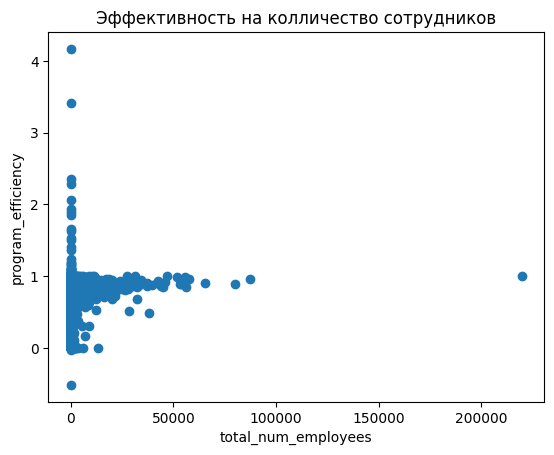

In [40]:
plt.scatter(kpi_df_clean2['total_num_employees'], kpi_df_clean2['program_efficiency'])
plt.title('Эффективность на колличество сотрудников')
plt.xlabel('total_num_employees')
plt.ylabel('program_efficiency')
plt.show()

In [41]:
# Колличество сотрудников ломает график. Инфа по мини ТНК мне не нужна. Сначала брал наугад 5000 человек и оказалось разница начинается с 2000
# Верхние значения оказались со слишким большим разрывом по program_efficiency, и малым колличеством сотрудников, что непригодно для нашего анализа.
# Поэтому мы отфильтруем строки, кже число сотрудников меньше 3
kpi_df_clean3 = (
    kpi_df_clean2
    .filter(
        (pl.col("total_num_employees") < 2000)
    ))
kpi_df_clean3.describe()

shape: (9, 9)
┌────────────┬──────────────┬──────────────┬──────────────┬───┬──────────────┬─────────────┬─────────────┬─────────────┐
│ statistic  ┆ business_nam ┆ formation_ye ┆ program_effi ┆ … ┆ staff_intens ┆ volunteer_l ┆ total_num_v ┆ total_num_e │
│ ---        ┆ e_ln1        ┆ ar           ┆ ciency       ┆   ┆ ity          ┆ everage     ┆ olunteers   ┆ mployees    │
│ str        ┆ ---          ┆ ---          ┆ ---          ┆   ┆ ---          ┆ ---         ┆ ---         ┆ ---         │
│            ┆ str          ┆ f64          ┆ f64          ┆   ┆ f64          ┆ f64         ┆ f64         ┆ f64         │
╞════════════╪══════════════╪══════════════╪══════════════╪═══╪══════════════╪═════════════╪═════════════╪═════════════╡
│ count      ┆ 87139        ┆ 87139.0      ┆ 87139.0      ┆ … ┆ 87139.0      ┆ 87139.0     ┆ 87139.0     ┆ 87139.0     │
│ null_count ┆ 0            ┆ 0.0          ┆ 0.0          ┆ … ┆ 0.0          ┆ 0.0         ┆ 0.0         ┆ 0.0         │
│ mean       ┆ null         ┆ 1981.157932  ┆ 0.808092     ┆ … ┆ 0.000033     ┆ 21.850783   ┆ 786.171278  ┆ 105.003569  │
│ std        ┆ null         ┆ 29.935374    ┆ 0.149954     ┆ … ┆ 0.000637     ┆ 497.258088  ┆ 26006.35995 ┆ 226.296468  │
│            ┆              ┆              ┆              ┆   ┆              ┆             ┆ 8           ┆             │
│ min        ┆ 'AHA PUNANA  ┆ 1208.0       ┆ -0.514167    ┆ … ┆ 2.0052e-9    ┆ 0.0         ┆ 0.0         ┆ 4.0         │
│            ┆ LEO INC      ┆              ┆              ┆   ┆              ┆             ┆             ┆             │
│ 25%        ┆ null         ┆ 1970.0       ┆ 0.751775     ┆ … ┆ 0.000009     ┆ 0.148148    ┆ 9.0         ┆ 10.0        │
│ 50%        ┆ null         ┆ 1987.0       ┆ 0.833325     ┆ … ┆ 0.000017     ┆ 1.2         ┆ 35.0        ┆ 25.0        │
│ 75%        ┆ null         ┆ 2002.0       ┆ 0.900006     ┆ … ┆ 0.000031     ┆ 5.882353    ┆ 150.0       ┆ 85.0        │
│ max        ┆ zero8hundred ┆ 2109.0       ┆ 4.166458     ┆ … ┆ 0.110497     ┆ 58360.66666 ┆ 3e6         ┆ 1998.0      │
│            ┆ Inc          ┆              ┆              ┆   ┆              ┆ 7           ┆             ┆             │
└────────────┴──────────────┴──────────────┴──────────────┴───┴──────────────┴─────────────┴─────────────┴─────────────┘

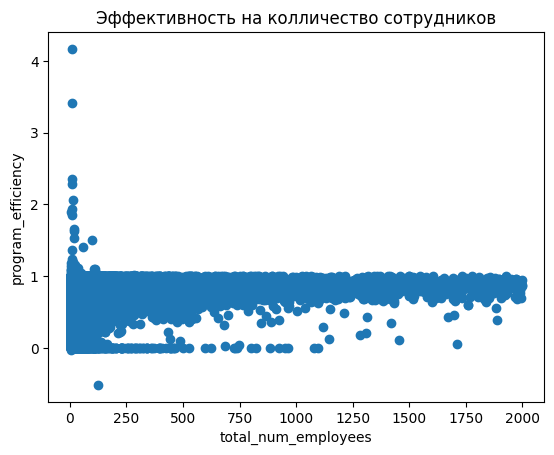

In [42]:
plt.scatter(kpi_df_clean3['total_num_employees'], kpi_df_clean3['program_efficiency'])
plt.title('Эффективность на колличество сотрудников')
plt.xlabel('total_num_employees')
plt.ylabel('program_efficiency')
plt.show()

In [43]:
kpi_df_clean3.head(10)

shape: (10, 8)
┌──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬─────────────┐
│ business_nam ┆ formation_ye ┆ program_effi ┆ admin_burden ┆ staff_intens ┆ volunteer_le ┆ total_num_vo ┆ total_num_e │
│ e_ln1        ┆ ar           ┆ ciency       ┆ ---          ┆ ity          ┆ verage       ┆ lunteers     ┆ mployees    │
│ ---          ┆ ---          ┆ ---          ┆ f64          ┆ ---          ┆ ---          ┆ ---          ┆ ---         │
│ str          ┆ i64          ┆ f64          ┆              ┆ f64          ┆ f64          ┆ i64          ┆ i64         │
╞══════════════╪══════════════╪══════════════╪══════════════╪══════════════╪══════════════╪══════════════╪═════════════╡
│ JONATHAN     ┆ 1987         ┆ 4.166458     ┆ 0.024169     ┆ 0.000094     ┆ 17.727273    ┆ 195          ┆ 11          │
│ STOOPS POST  ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ 7084 VFW     ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ EVERGREEN    ┆ 1933         ┆ 3.416132     ┆ 0.0          ┆ 0.000086     ┆ 5.625        ┆ 45           ┆ 8           │
│ COUNTRY CLUB ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ INC          ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ American     ┆ 1947         ┆ 2.347006     ┆ 0.079253     ┆ 0.000136     ┆ 2.727273     ┆ 30           ┆ 11          │
│ Legion Post  ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ 168          ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ VETERANS OF  ┆ 1964         ┆ 2.278403     ┆ 0.102364     ┆ 0.00004      ┆ 0.111111     ┆ 1            ┆ 9           │
│ FOREIGN WARS ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ OF TH…       ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ AMERICAN     ┆ 1946         ┆ 2.065971     ┆ 0.097581     ┆ 0.000017     ┆ 70.8         ┆ 1062         ┆ 15          │
│ LEGION POST  ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ 284          ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ AMERICAN     ┆ 1987         ┆ 1.934836     ┆ 0.219431     ┆ 0.000059     ┆ 2.0          ┆ 14           ┆ 7           │
│ LEGION POST  ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ 138          ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ FOX LAKE     ┆ 1950         ┆ 1.892599     ┆ 0.0067       ┆ 0.000001     ┆ 3.75         ┆ 15           ┆ 4           │
│ CONSERVATION ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ LEAGUE I…    ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ MENARD CNTY  ┆ 1978         ┆ 1.845326     ┆ 0.03074      ┆ 0.000107     ┆ 1.142857     ┆ 8            ┆ 7           │
│ VFW POST     ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ 6871         ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ Community    ┆ 1978         ┆ 1.650487     ┆ -0.650487    ┆ 0.000004     ┆ 4.5          ┆ 72           ┆ 16          │
│ Resources    ┆              ┆              ┆              ┆              ┆              ┆              ┆             │
│ for Childr…  ┆              ┆              ┆              ┆              ┆              ┆              ┆       

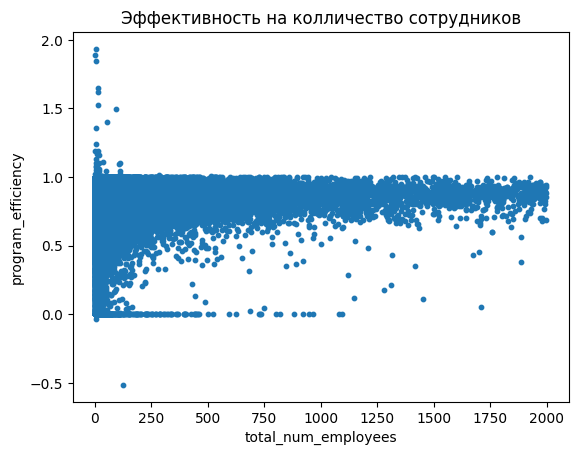

In [44]:
# program_efficiency > 2 очевидно выбросы
kpi_df_clean4 = (
    kpi_df_clean3
    .filter(
        (pl.col("program_efficiency") < 2)
    ))
plt.scatter(kpi_df_clean4['total_num_employees'], kpi_df_clean4['program_efficiency'], s=10)
plt.title('Эффективность на колличество сотрудников')
plt.xlabel('total_num_employees')
plt.ylabel('program_efficiency')
plt.show()

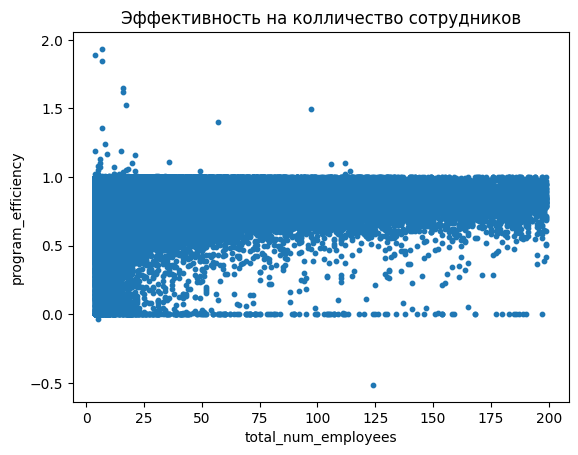

In [45]:
# Пока что можно сказать что большинство организаций по этому показателю имеют одинаковую эффективность.
# Однако аномально высокие показатели встречаются в основном до 200 человек, а заниженные после 200 человек.
# Можно ещё проверить по волонтёрам, но для начало получим более точные цифры.
kpi_df_clean5 = (
    kpi_df_clean4
    .filter(
        (pl.col("total_num_employees") < 200)
    ))
plt.scatter(kpi_df_clean5['total_num_employees'], kpi_df_clean5['program_efficiency'], s=10)
plt.title('Эффективность на колличество сотрудников')
plt.xlabel('total_num_employees')
plt.ylabel('program_efficiency')
plt.show()

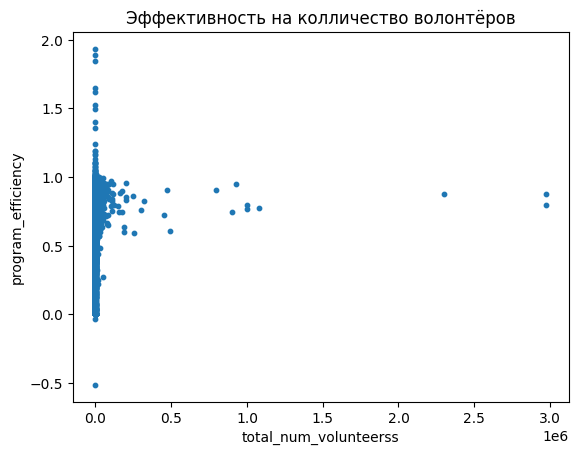

In [46]:
# Если остмечать некие качественные скачки, то визуально их можно увидеть на 25, 50 и 175 человек.
# Проверим вносит ли разницу колличество волонтёров
plt.scatter(kpi_df_clean5['total_num_volunteers'], kpi_df_clean5['program_efficiency'], s=10)
plt.title('Эффективность на колличество волонтёров')
plt.xlabel('total_num_volunteerss')
plt.ylabel('program_efficiency')
plt.show()

In [47]:
kpi_df_clean5.describe()

shape: (9, 9)
┌────────────┬──────────────┬──────────────┬──────────────┬───┬──────────────┬─────────────┬─────────────┬─────────────┐
│ statistic  ┆ business_nam ┆ formation_ye ┆ program_effi ┆ … ┆ staff_intens ┆ volunteer_l ┆ total_num_v ┆ total_num_e │
│ ---        ┆ e_ln1        ┆ ar           ┆ ciency       ┆   ┆ ity          ┆ everage     ┆ olunteers   ┆ mployees    │
│ str        ┆ ---          ┆ ---          ┆ ---          ┆   ┆ ---          ┆ ---         ┆ ---         ┆ ---         │
│            ┆ str          ┆ f64          ┆ f64          ┆   ┆ f64          ┆ f64         ┆ f64         ┆ f64         │
╞════════════╪══════════════╪══════════════╪══════════════╪═══╪══════════════╪═════════════╪═════════════╪═════════════╡
│ count      ┆ 75476        ┆ 75476.0      ┆ 75476.0      ┆ … ┆ 75476.0      ┆ 75476.0     ┆ 75476.0     ┆ 75476.0     │
│ null_count ┆ 0            ┆ 0.0          ┆ 0.0          ┆ … ┆ 0.0          ┆ 0.0         ┆ 0.0         ┆ 0.0         │
│ mean       ┆ null         ┆ 1984.031281  ┆ 0.803016     ┆ … ┆ 0.000032     ┆ 24.348825   ┆ 573.7805    ┆ 37.447427   │
│ std        ┆ null         ┆ 27.071482    ┆ 0.15409      ┆ … ┆ 0.000578     ┆ 531.069216  ┆ 20002.84069 ┆ 42.94883    │
│            ┆              ┆              ┆              ┆   ┆              ┆             ┆ 4           ┆             │
│ min        ┆ 'AHA PUNANA  ┆ 1645.0       ┆ -0.514167    ┆ … ┆ 2.0052e-9    ┆ 0.0         ┆ 0.0         ┆ 4.0         │
│            ┆ LEO INC      ┆              ┆              ┆   ┆              ┆             ┆             ┆             │
│ 25%        ┆ null         ┆ 1973.0       ┆ 0.743488     ┆ … ┆ 0.000009     ┆ 0.25        ┆ 8.0         ┆ 8.0         │
│ 50%        ┆ null         ┆ 1990.0       ┆ 0.827792     ┆ … ┆ 0.000017     ┆ 1.666667    ┆ 30.0        ┆ 19.0        │
│ 75%        ┆ null         ┆ 2003.0       ┆ 0.900323     ┆ … ┆ 0.000031     ┆ 7.25        ┆ 132.0       ┆ 48.0        │
│ max        ┆ zero8hundred ┆ 2109.0       ┆ 1.934836     ┆ … ┆ 0.110497     ┆ 58360.66666 ┆ 2.976394e6  ┆ 199.0       │
│            ┆ Inc          ┆              ┆              ┆   ┆              ┆ 7           ┆             ┆             │
└────────────┴──────────────┴──────────────┴──────────────┴───┴──────────────┴─────────────┴─────────────┴─────────────┘

In [48]:
kpi_df_clean5['total_num_volunteers'].max()

2976394

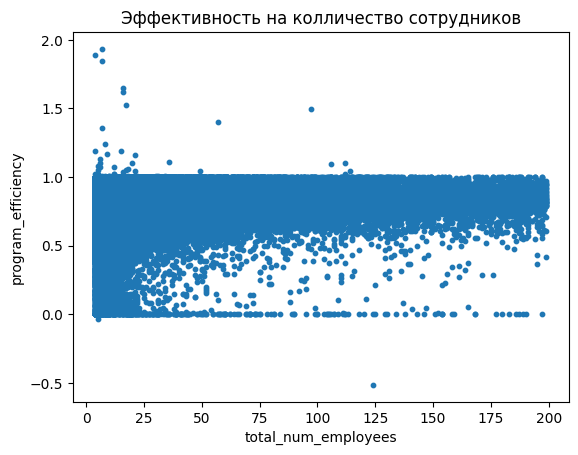

In [49]:
# Надо фильтровать ещё раз, так как затесались строки, где слишком много волонтёров и это очевидно выбросы на фоне других организаций
kpi_df_clean6 = (
    kpi_df_clean5
    .filter(
        (pl.col("total_num_volunteers") < 200)
    ))
plt.scatter(kpi_df_clean6['total_num_employees'], kpi_df_clean6['program_efficiency'], s=10)
plt.title('Эффективность на колличество сотрудников')
plt.xlabel('total_num_employees')
plt.ylabel('program_efficiency')
plt.show()

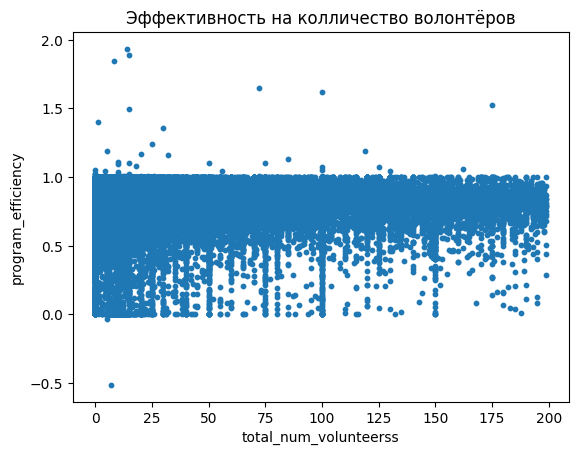

In [50]:
# Разнице в графике почти нет, поэтому не будем пересматривать выводы. Посмотрим что с стало бы колиичеством сотрудников, если прибавить волонтёров
plt.scatter(kpi_df_clean6['total_num_volunteers'], kpi_df_clean6['program_efficiency'], s=10)
plt.title('Эффективность на колличество волонтёров')
plt.xlabel('total_num_volunteerss')
plt.ylabel('program_efficiency')
plt.show()

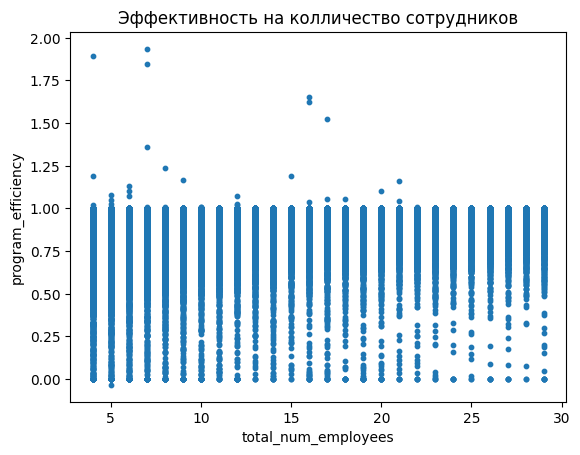

In [51]:
# Отличие от числа сотрудников лишь в том, что один из скачков визуально кажется начинается с 125, а не 175.
# Имеет смысл задать вопрос, будет ли разница если посчитать их вместе, однако вряд ли такие организации часто встречкается и скорее всего нет разницы.
# Посмотрим есть отличия для 25 сотрудников, если считать их за один отдел организации. Взяд 30 для запаса
kpi_df_clean7 = (
    kpi_df_clean6
    .filter(
        (pl.col("total_num_employees") < 30)
    ))
plt.scatter(kpi_df_clean7['total_num_employees'], kpi_df_clean7['program_efficiency'], s=10)
plt.title('Эффективность на колличество сотрудников')
plt.xlabel('total_num_employees')
plt.ylabel('program_efficiency')
plt.show()

In [52]:
# Скачки бывают после каждых 5 человек, однако самый крупный по прежднему после 25. 
# У нас есть хоть какие-то цифры, попробуем отследить их по другим случаям.
# На Kaggle нашёл 3 df на тему образования с разделением на колличество человек и проектов: проффесора, турецкие студенты и французские исследователи.
# Возмём пока 3 вариант, как более универсальный и ближе к оргструктуре https://www.kaggle.com/datasets/syedhaseebahmad/irit-researchers-database
db.sql(f"""
CREATE OR REPLACE TEMP TABLE IRIT AS
SELECT *
FROM read_csv_auto(
    'IRIT_Researchers_Database.csv'
)
""")

db.sql("SELECT * FROM IRIT LIMIT 5").df()

AuthorID (authorpublication)  AuthorID (authorrgroup)  Author ID  \
0                       2000000                  2000000    2000000   
1                       2000154                  2000154    2000154   
2                       2000000                  2000000    2000000   
3                       2000166                  2000166    2000166   
4                       2000301                  2000301    2000301   

   Pub per author  Marketshare2021  Marketshare2020  Marketshare2019  \
0               1         0.005478         0.007656         0.007434   
1               1         0.005478         0.007656         0.007434   
2               1         0.005478         0.007656         0.007434   
3               1         0.005478         0.007656         0.007434   
4               1         0.005478         0.007656         0.007434   

   Marketshare2018  Marketshare2017 Con Acronym  ...  R Group Country  \
0         0.007607         0.009268        HiPC  ...           France   
1         0.007607         0.009268        HiPC  ...           France   
2         0.007607         0.009268      ICPADS  ...           France   
3         0.007607         0.009268      ICPADS  ...           France   
4         0.007607         0.009268      ICPADS  ...           France   

   R Group Full Name  RGroupID (researchgroup) R Group ID R Group Name  \
0               CISO                   1000000    1000000          APO   
1                 GD                   1000004    1000004          GIS   
2               CISO                   1000000    1000000          APO   
3                 GD                   1000004    1000004          GIS   
4                 IA                   1000007    1000007       MELODI   

  SubID (subjectarea)   Sub ID                                    Sub Name  \
0             4000000  4000000  Distributed computing and systems software   
1             4000000  4000000  Distributed computing and systems software   
2             4000000  4000000  Distributed computing and systems software   
3             4000000  4000000  Distributed computing and systems software   
4             4000000  4000000  Distributed computing and systems software   

   Surname  University  
0  BUTTARI        CNRS  
1     DIOP        None  
2  BUTTARI        CNRS  
3       LI        None  
4   SANTOS        None  

[5 rows x 34 columns]

In [53]:
IRIT = db.sql("SELECT * FROM IRIT").pl()
IRIT.columns

['AuthorID (authorpublication)',
 'AuthorID (authorrgroup)',
 'Author ID',
 'Pub per author',
 'Marketshare2021',
 'Marketshare2020',
 'Marketshare2019',
 'Marketshare2018',
 'Marketshare2017',
 'Con Acronym',
 'ConID (conference)',
 'ConID (conferencesubject)',
 'Con ID',
 'Con Name',
 'Con Rank',
 'First Name',
 'Job Type',
 'Number of Records',
 'Org ID',
 'PubID (publication)',
 'Pub ID',
 'Pub Name',
 'Pub Type',
 'Pub Year',
 'R Group Country',
 'R Group Full Name',
 'RGroupID (researchgroup)',
 'R Group ID',
 'R Group Name',
 'SubID (subjectarea)',
 'Sub ID',
 'Sub Name',
 'Surname',
 'University']

In [54]:
# Выбираем какие колонки использовать в коде.
print(db.sql("""SELECT DISTINCT "R Group Name" FROM IRIT""")) # Выборка оказалось больше
print(db.sql("""SELECT DISTINCT "R Group Full Name" FROM IRIT"""))
print(IRIT["PubID (publication)"].n_unique())
print(IRIT["Pub ID"].n_unique())
print(IRIT["Pub Name"].n_unique()) # Видимо одно имя отсуствует или в этом роде

┌──────────────┐
│ R Group Name │
│   varchar    │
├──────────────┤
│ MELODI       │
│ LILaC        │
│ TALENT       │
│ APO          │
│ ACADIE       │
│ REVA         │
│ IRIS         │
│ GIS          │
│ ADRIA        │
│ PYRAMID      │
│ SMART        │
│ ELIPSE       │
│ SMAC         │
│ ARGOS        │
├──────────────┤
│   14 rows    │
└──────────────┘

┌───────────────────┐
│ R Group Full Name │
│      varchar      │
├───────────────────┤
│ GD                │
│ CISO              │
│ IA                │
│ FSL               │
│ ICI               │
└───────────────────┘

2952
2952
2951


In [55]:
# Решил посмотреть в каком виде данные храняться в колонках - именна, индекссы и т.д. И чему соотвествует каждая строка - публикации или ещё чему
print(IRIT.head(1).glimpse())

Rows: 1
Columns: 34
$ AuthorID (authorpublication) <i64> 2000000
$ AuthorID (authorrgroup)      <i64> 2000000
$ Author ID                    <i64> 2000000
$ Pub per author               <i64> 1
$ Marketshare2021              <f64> 0.005478251
$ Marketshare2020              <f64> 0.007656382
$ Marketshare2019              <f64> 0.007433839
$ Marketshare2018              <f64> 0.007607455
$ Marketshare2017              <f64> 0.009267841
$ Con Acronym                  <str> 'HiPC'
$ ConID (conference)           <i64> 3000000
$ ConID (conferencesubject)    <i64> 3000000
$ Con ID                       <i64> 3000000
$ Con Name                     <str> 'International Conference on High Performance Computing'
$ Con Rank                     <str> 'National: India'
$ First Name                   <str> 'Alfredo'
$ Job Type                     <str> 'Permanent'
$ Number of Records            <i64> 1
$ Org ID                       <str> null
$ PubID (publication)          <i64> 5000013
$ Pub ID   

In [56]:
IRIT_Uniq_RG_and_Author_ID = IRIT.select(pl.struct(["Author ID", "R Group Name"]).unique())
print(IRIT_Uniq_RG_and_Author_ID)

shape: (261, 1)
┌────────────────────┐
│ Author ID          │
│ ---                │
│ struct[2]          │
╞════════════════════╡
│ {2000416,"TALENT"} │
│ {2000433,"ACADIE"} │
│ {2000128,"GIS"}    │
│ {2000236,"ADRIA"}  │
│ {2000267,"MELODI"} │
│ …                  │
│ {2000303,"MELODI"} │
│ {2000422,"ACADIE"} │
│ {2000130,"GIS"}    │
│ {2000316,"ELIPSE"} │
│ {2000186,"ADRIA"}  │
└────────────────────┘


In [57]:
result = (
    IRIT.group_by("R Group Name")
    .agg([
        pl.col("Author ID").n_unique().alias("Count_Authors"),
        pl.col("Author ID").unique().alias("List_of_Authors"),
        pl.col("Pub ID").n_unique().alias("Count_Publication")
    ])
)
print(result)

shape: (14, 4)
┌──────────────┬───────────────┬───────────────────────────────┬───────────────────┐
│ R Group Name ┆ Count_Authors ┆ List_of_Authors               ┆ Count_Publication │
│ ---          ┆ ---           ┆ ---                           ┆ ---               │
│ str          ┆ u32           ┆ list[i64]                     ┆ u32               │
╞══════════════╪═══════════════╪═══════════════════════════════╪═══════════════════╡
│ APO          ┆ 15            ┆ [2000000, 2000004, … 2000019] ┆ 126               │
│ LILaC        ┆ 20            ┆ [2000240, 2000265, … 2000251] ┆ 321               │
│ IRIS         ┆ 15            ┆ [2000104, 2000113, … 2000102] ┆ 237               │
│ TALENT       ┆ 9             ┆ [2000401, 2000416, … 2000412] ┆ 63                │
│ PYRAMID      ┆ 4             ┆ [2000119, 2000121, … 2000120] ┆ 36                │
│ …            ┆ …             ┆ …                             ┆ …                 │
│ MELODI       ┆ 27            ┆ [2000301, 2000296

In [58]:
result = (result
    .with_columns([
        (pl.col("Count_Authors") / pl.col("Count_Publication")).alias("Author/Publication")])
    .sort("Author/Publication", descending=True)
)
print(result)

shape: (14, 5)
┌──────────────┬───────────────┬───────────────────────────────┬───────────────────┬────────────────────┐
│ R Group Name ┆ Count_Authors ┆ List_of_Authors               ┆ Count_Publication ┆ Author/Publication │
│ ---          ┆ ---           ┆ ---                           ┆ ---               ┆ ---                │
│ str          ┆ u32           ┆ list[i64]                     ┆ u32               ┆ f64                │
╞══════════════╪═══════════════╪═══════════════════════════════╪═══════════════════╪════════════════════╡
│ SMAC         ┆ 29            ┆ [2000346, 2000336, … 2000383] ┆ 182               ┆ 0.159341           │
│ ARGOS        ┆ 8             ┆ [2000451, 2000452, … 2000453] ┆ 52                ┆ 0.153846           │
│ TALENT       ┆ 9             ┆ [2000401, 2000416, … 2000412] ┆ 63                ┆ 0.142857           │
│ REVA         ┆ 28            ┆ [2000043, 2000057, … 2000086] ┆ 234               ┆ 0.119658           │
│ APO          ┆ 15            

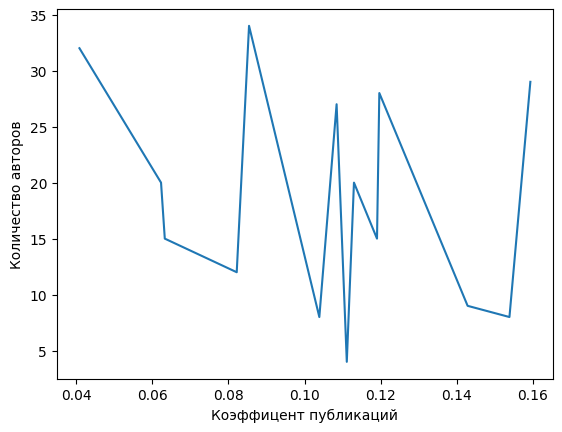

In [59]:
plt.plot(result['Author/Publication'], result['Count_Authors'])
plt.xlabel('Коэффицент публикаций')
plt.ylabel('Количество авторов')
plt.show()

In [60]:
# Результаты схожи: при том что некоторые постороние факторы меют больший вклад, наблюдается зависимость от колличества сотрудников.
# Показатели бывают одинаковы для разных размеров команд, но чем больше команда, тем в диапазоне возможных значений публикаций меньше.
# Диапазоны примерно равны на этом отрезке от 5 до 35, скачки через 3-5 человек, но они скорее графические, без качественного смысла.

In [61]:
# Для продолжения исследование были доступны ещё датосеты об образовании, белыъ воротничков и специфических отрослей.
# Выбран был датосет о сельском хозяйстве Индии https://www.kaggle.com/datasets/jayesh134/mgnrega-bridging-gaps-in-rural-india
# Цель - проверить работают те же закономерности для массовых отраслей с более низкой производительностью труда.
db.sql(f"""
CREATE OR REPLACE TEMP TABLE NREGA AS
SELECT *
FROM read_csv_auto(
    'NREGA.csv'
)
""")

db.sql("SELECT * FROM NREGA LIMIT 5").df()

state_name             district_name  \
0  ANDAMAN AND NICOBAR                  NICOBARS   
1  ANDAMAN AND NICOBAR  NORTH AND MIDDLE ANDAMAN   
2  ANDAMAN AND NICOBAR             SOUTH ANDAMAN   
3       ANDHRA PRADESH                SRIKAKULAM   
4       ANDHRA PRADESH              VIZIANAGARAM   

   Total No. of JobCards issued  Total No. of Workers  \
0                          6173                  9866   
1                         18521                 29500   
2                         13726                 17491   
3                        445787                743762   
4                        388651                694622   

   Total No. of Active Job Cards  Total No. of Active Workers  \
0                           1007                         2011   
1                           6477                        11920   
2                           3420                         5016   
3                         384349                       680409   
4                         350587                       648430   

   SC workers against active workers  ST workers against active workers  \
0                                  0                               1678   
1                                  0                                  0   
2                                  0                                  0   
3                              62310                              39751   
4                              76009                              18149   

   Approved Labour Budget  Persondays of Central Liability so far  ...  \
0                   34000                                    5046  ...   
1                   76000                                   30487  ...   
2                   40000                                    4522  ...   
3                16700000                                15568613  ...   
4                16800000                                15501082  ...   

   Total No. of Works Takenup (New+Spill Over)  Number of Ongoing Works  \
0                                          172                      172   
1                                          532                      458   
2                                          401                      174   
3                                        65095                    47441   
4                                        62481                    49931   

   Number of Completed Works  % of NRM Expenditure(Public + Individual)  \
0                          0                                      95.68   
1                         74                                      43.53   
2                        227                                      14.10   
3                      17654                                      77.36   
4                      12550                                      84.58   

   % of Category B Works  \
0                      5   
1                     41   
2                     44   
3                     58   
4                     58   

   % of Expenditure on Agriculture & Agriculture Allied Works  \
0                                               4.32            
1                                              29.34            
2                                              16.50            
3                                              14.91            
4                                               5.32            

   Total Exp(Rs. in Lakhs.)  Wages(Rs. In Lakhs)  \
0                  5.470080              5.47008   
1                167.966502            162.73531   
2                 79.200820             75.12606   
3              50704.068270          39336.94327   
4              48338.747750          37409.92904   

   Material and skilled Wages(Rs. In Lakhs)  \
0                                  0.000000   
1                                  5.231192   
2                                  1.374760   
3                              10037.246630   
4                               9966.570016   

   Total Ad

In [62]:
NREGA = db.sql("SELECT * FROM NREGA").pl()
NREGA.columns # Описание колонок соотвествуют описанию датосета

['state_name',
 'district_name',
 'Total No. of JobCards issued',
 'Total No. of Workers',
 'Total No. of Active Job Cards',
 'Total No. of Active Workers',
 'SC workers against active workers',
 'ST workers against active workers',
 'Approved Labour Budget',
 'Persondays of Central Liability so far',
 'SC persondays',
 'ST persondays',
 'Women Persondays',
 'Average days of employment provided per Household',
 'Average Wage rate per day per person(Rs.)',
 'Total No of HHs completed 100 Days of Wage Employment',
 'Total Households Worked',
 'Total Individuals Worked',
 'Differently abled persons worked',
 'Number of GPs with NIL exp',
 'Total No. of Works Takenup (New+Spill Over)',
 'Number of Ongoing Works',
 'Number of Completed Works',
 '% of NRM Expenditure(Public + Individual)',
 '% of Category B Works',
 '% of Expenditure on Agriculture & Agriculture Allied Works',
 'Total Exp(Rs. in Lakhs.)',
 'Wages(Rs. In Lakhs)',
 'Material and skilled Wages(Rs. In Lakhs)',
 'Total Adm Expend

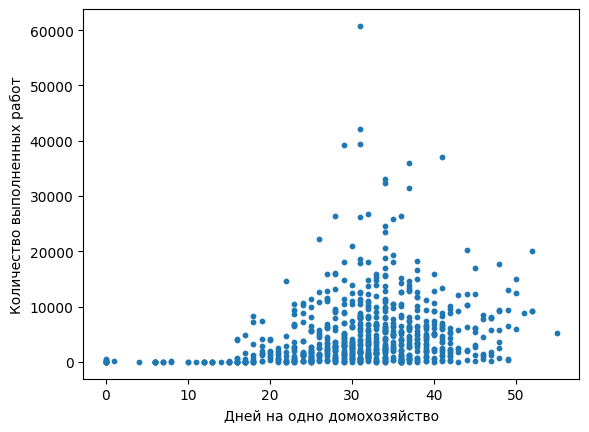

In [63]:
NREGA = (NREGA.sort("Average days of employment provided per Household", descending=True))
plt.scatter(NREGA['Average days of employment provided per Household'], NREGA['Number of Completed Works'], s=10)
plt.xlabel('Дней на одно домохозяйство')
plt.ylabel('Количество выполненных работ')
plt.show()

In [64]:
# Распределение близко к нормальному, но также смущает всреднем 35 трудодней на домохозяйство. Такие данные нам не подходят.
# Попробуем ещё один набор данных о комерческой сфере, с разделением на отрослои труда. https://www.kaggle.com/datasets/zahidmughal2343/employee-data
db.sql(f"""
CREATE OR REPLACE TEMP TABLE Employee AS
SELECT *
FROM read_csv_auto(
    'Employee 1000x.csv'
)
""")

db.sql("SELECT * FROM Employee LIMIT 5").df()

Index First Name Last Name     Sex                        Email  \
0      1       Sara   Mcguire  Female           tsharp@example.net   
1      2     Alisha    Hebert    Male   vincentgarrett@example.net   
2      3  Gwendolyn  Sheppard    Male  mercadojonathan@example.com   
3      4   Kristine    Mccann  Female        lindsay55@example.com   
4      5      Bobby   Pittman  Female    blevinsmorgan@example.com   

                   Phone Date of birth                          Job Title  
0     (971)643-6089x9160    2021-08-17              Editor, commissioning  
1  +1-114-355-1841x78347    1969-06-28                 Broadcast engineer  
2             9017807728    2015-09-25                   Industrial buyer  
3  +1-607-333-9911x59088    1978-07-27              Multimedia specialist  
4             3739847538    1989-11-17  Planning and development surveyor

In [65]:
# Описание оказалось недействительным, здесь нет нужных данных.
# Остались лишь по отдельным отрослям. Пробуем про больнииы https://www.kaggle.com/datasets/olagokeblissman/luth-hospital-enhanced-dataset
db.sql(f"""
CREATE OR REPLACE TEMP TABLE LUTH AS
SELECT *
FROM read_xlsx(
    'LUTH_Hospital_Enhanced_Dataset.xlsx'
)
""")

db.sql("SELECT * FROM LUTH LIMIT 5").df()

Patient ID       Name   Age  Gender   Department  Diagnosis      Treatment  \
0  LUTH-1000  Patient_1  44.0  Female     Oncology    Malaria        Surgery   
1  LUTH-1001  Patient_2  51.0    Male    Neurology     Cancer       Referral   
2  LUTH-1002  Patient_3  20.0  Female   Cardiology   Fracture  Physiotherapy   
3  LUTH-1003  Patient_4  73.0    Male  Orthopedics  Infection  Physiotherapy   
4  LUTH-1004  Patient_5  78.0    Male   Pediatrics   Fracture        Surgery   

        Doctor Visit Date  Stay Duration (days)  Cost (Naira)    Ward  \
0      Dr. Obi 2024-02-21                  10.0     243721.97  Ward D   
1    Dr. Bello 2024-11-22                  13.0     150679.18  Ward C   
2  Dr. Johnson 2024-09-18                  14.0      97198.81  Ward E   
3   Dr. Okafor 2024-09-14                  11.0     178102.61  Ward E   
4     Dr. Musa 2024-07-08                  15.0     201972.05  Ward E   

  Payment Method            Outcome Follow-Up Required  \
0           Cash           Deceased                 No   
1      Insurance  Under Observation                 No   
2           Cash           Deceased                Yes   
3           Card          Recovered                 No   
4      Insurance           Referred                 No   

   Satisfaction Score (1-5)       Admission Time       Discharge Time  
0                       4.0  2024-02-21 13:13:00  2024-03-02 13:13:00  
1                       1.0  2024-11-22 17:22:00  2024-12-05 17:22:00  
2                       4.0  2024-09-18 10:34:00  2024-10-02 10:34:00  
3                       3.0  2024-09-14 11:34:00  2024-09-25 11:34:00  
4                       4.0  2024-07-08 14:52:00  2024-07-23 14:52:00

In [66]:
LUTH = db.sql("SELECT * FROM LUTH").pl()
LUTH.columns # Описание колонок соотвествуют описанию датосета

['Patient ID',
 'Name',
 'Age',
 'Gender',
 'Department',
 'Diagnosis',
 'Treatment',
 'Doctor',
 'Visit Date',
 'Stay Duration (days)',
 'Cost (Naira)',
 'Ward',
 'Payment Method',
 'Outcome',
 'Follow-Up Required',
 'Satisfaction Score (1-5)',
 'Admission Time',
 'Discharge Time']

In [67]:
LUTH_result = (
    LUTH.group_by("Ward")
    .agg([
        pl.col("Doctor").n_unique().alias("Count_Doctor"),
        pl.col("Discharge Time").n_unique().alias("Count_Discharg")
    ])
)
print(LUTH_result)

shape: (5, 3)
┌────────┬──────────────┬────────────────┐
│ Ward   ┆ Count_Doctor ┆ Count_Discharg │
│ ---    ┆ ---          ┆ ---            │
│ str    ┆ u32          ┆ u32            │
╞════════╪══════════════╪════════════════╡
│ Ward A ┆ 7            ┆ 111            │
│ Ward D ┆ 7            ┆ 82             │
│ Ward B ┆ 7            ┆ 99             │
│ Ward C ┆ 7            ┆ 106            │
│ Ward E ┆ 7            ┆ 102            │
└────────┴──────────────┴────────────────┘


In [68]:
# В больнице оказалось всего 7 докторов, так что эти данные нам не подошли 
db.sql("SELECT DISTINCT Doctor FROM LUTH")

┌─────────────┐
│   Doctor    │
│   varchar   │
├─────────────┤
│ Dr. Johnson │
│ Dr. Okafor  │
│ Dr. Musa    │
│ Dr. Obi     │
│ Dr. Bello   │
│ Dr. Ahmed   │
│ Dr. Adeyemi │
└─────────────┘

In [69]:
# https://www.kaggle.com/datasets/johnp47/communities-and-crime-dataset попробуем посчитать сколько полицейских и сколько ловят
db.sql(f"""
CREATE OR REPLACE TEMP TABLE Crime AS
SELECT *
FROM read_text(
    'CommViolPredUnnormalizedData.txt'
)
""")

db.sql("SELECT * FROM Crime LIMIT 5").df()

filename  \
0  CommViolPredUnnormalizedData.txt   

                                             content     size  \
0  BerkeleyHeightstownship,NJ,39,5320,1,11980,3.1...  1555749   

              last_modified  
0 2026-01-21 10:00:15+05:00

In [70]:
# db.sql("SELECT * FROM Crime") # Для проверки что это за файл, но необязательно и закоментчино чтобы не грузило систему

In [71]:
# Оказалось это не txt, а csv с разделителем ','
Crime = db.sql("""
    SELECT *
    FROM read_csv_auto(
        'CommViolPredUnnormalizedData.txt',
        delim=',',
        header=false,
        nullstr='?'
    )
""").df()
print(Crime.head())

                 column000 column001  column002  column003  column004  \
0  BerkeleyHeightstownship        NJ         39       5320          1   
1           Marpletownship        PA         45      47616          1   
2               Tigardcity        OR       <NA>       <NA>          1   
3         Gloversvillecity        NY         35      29443          1   
4              Bemidjicity        MN          7       5068          1   

   column005  column006  column007  column008  column009  ...  column137  \
0      11980       3.10       1.37      91.78       6.50  ...         14   
1      23123       2.82       0.80      95.57       3.44  ...         57   
2      29344       2.43       0.74      94.33       3.43  ...        274   
3      16656       2.40       1.70      97.35       0.50  ...        225   
4      11245       2.76       0.53      89.16       1.17  ...         91   

   column138  column139  column140  column141  column142  column143  \
0     114.85        138    1132.0

In [75]:
# В описании на kaggle есть названия колонок отдельно в "Attribute Information", из них я собрал column_names.txt
# Первую строку "'(125 predictive, 4 non-predictive, 18 potential goal) '," не копируем из остальных автозаменой удаляем ' и запятые.
Crime = pl.read_csv(
    "CommViolPredUnnormalizedData.txt",
    separator=",",
    has_header=False,
    null_values="?"
)

colnames = (
    pl.read_csv(
        "column_names.txt",
        has_header=False
    )
    .to_series()
    .to_list()
)

Crime.columns = colnames
print(Crime.head())

shape: (5, 147)
┌──────────────┬──────────────┬──────────────┬─────────────┬───┬─────────────┬─────────────┬─────────────┬─────────────┐
│ communitynam ┆ state: US    ┆ countyCode:  ┆ communityCo ┆ … ┆ arsons:     ┆ arsonsPerPo ┆ ViolentCrim ┆ nonViolPerP │
│ e: Community ┆ state (by 2  ┆ numeric code ┆ de: numeric ┆   ┆ number of   ┆ p: number   ┆ esPerPop:   ┆ op: total   │
│ name…        ┆ letter …     ┆ for …        ┆ code f…     ┆   ┆ arsons in   ┆ of arson…   ┆ total nu…   ┆ number o…   │
│ ---          ┆ ---          ┆ ---          ┆ ---         ┆   ┆ 1…          ┆ ---         ┆ ---         ┆ ---         │
│ str          ┆ str          ┆ i64          ┆ i64         ┆   ┆ ---         ┆ f64         ┆ f64         ┆ f64         │
│              ┆              ┆              ┆             ┆   ┆ i64         ┆             ┆             ┆             │
╞══════════════╪══════════════╪══════════════╪═════════════╪═══╪═════════════╪═════════════╪═════════════╪═════════════╡
│ BerkeleyHeig ┆

In [79]:
# Вручную колонки посмотреть сложно, так как строки большого размера и они сливаются друг друга при просмотре через переводчик.
# Не буду пока обращать внимания на социальные корни, недостатке финансирования, благополучии облости и т.д. Если увижу аномалии к этому перейду.
# Для начала посмотрю сколько полицейских успевают словить сколько преступников.
# С помощью GPT были отобраны ключивые слова-фонемы. Сам недостаточно знаю язык для этого.

cols = Crime.columns

police_cols = [
    c for c in cols
    if re.search(r"police|officer|cop", c, re.IGNORECASE)
]

crime_cols = [
    c for c in cols
    if re.search(r"crime|violent|murder|robbery|assault|burgl|larcen|auto|arson", c, re.IGNORECASE)
]

In [81]:
# Пишу в разных ячейках и не через print, так как в таком виде названия вынесены на отдельные строки
police_cols

[' LemasSwornFT: number of sworn full time police officers (numeric - expected to be integer) ',
 ' LemasSwFTPerPop: sworn full time police officers per 100K population (numeric - decimal) ',
 ' LemasSwFTFieldOps: number of sworn full time police officers in field operations (on the street as opposed to administrative etc) (numeric - expected to be integer) ',
 ' LemasSwFTFieldPerPop: sworn full time police officers in field operations (on the street as opposed to administrative etc) per 100K population (numeric - decimal) ',
 ' LemasTotalReq: total requests for police (numeric - expected to be integer) ',
 ' LemasTotReqPerPop: total requests for police per 100K popuation (numeric - decimal) ',
 ' PolicReqPerOffic: total requests for police per police officer (numeric - decimal) ',
 ' PolicPerPop: police officers per 100K population (numeric - decimal) ',
 ' RacialMatchCommPol: a measure of the racial match between the community and the police force. High values indicate proportions in

In [83]:
crime_cols

[' murders: number of murders in 1995 (numeric - expected to be integer) potential GOAL attribute (to be predicted) ',
 ' murdPerPop: number of murders per 100K population (numeric - decimal) potential GOAL attribute (to be predicted) ',
 ' assaults: number of assaults in 1995 (numeric - expected to be integer) potential GOAL attribute (to be predicted) ',
 ' assaultPerPop: number of assaults per 100K population (numeric - decimal) potential GOAL attribute (to be predicted) ',
 ' burglaries: number of burglaries in 1995 (numeric - expected to be integer) potential GOAL attribute (to be predicted) ',
 ' burglPerPop: number of burglaries per 100K population (numeric - decimal) potential GOAL attribute (to be predicted) ',
 ' larcenies: number of larcenies in 1995 (numeric - expected to be integer) potential GOAL attribute (to be predicted) ',
 ' larcPerPop: number of larcenies per 100K population (numeric - decimal) potential GOAL attribute (to be predicted) ',
 ' autoTheft: number of au

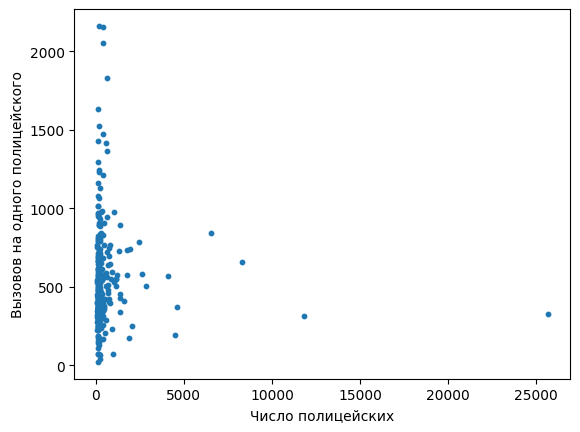

In [85]:
# Количество закрытых дел здесь не было, так что возмём запросы на вызов полиции на одного полицейского. 
# Число запросов тоже доступно, но так или иначе некий коэфициент эффективности, а здесь уже за меня посчитали.
plt.scatter(Crime[' LemasSwornFT: number of sworn full time police officers (numeric - expected to be integer) '], Crime[' PolicReqPerOffic: total requests for police per police officer (numeric - decimal) '], s=10)
plt.xlabel('Число полицейских')
plt.ylabel('Вызовов на одного полицейского')
plt.show()

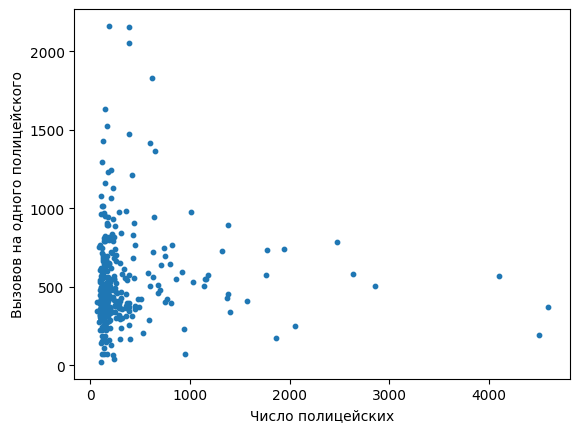

In [94]:
Crime_clean = (
    Crime.filter(
        (pl.col(" LemasSwornFT: number of sworn full time police officers (numeric - expected to be integer) ") < 5000)
    ))
plt.scatter(Crime_clean[' LemasSwornFT: number of sworn full time police officers (numeric - expected to be integer) '], Crime_clean[' PolicReqPerOffic: total requests for police per police officer (numeric - decimal) '], s=10)
plt.xlabel('Число полицейских')
plt.ylabel('Вызовов на одного полицейского')
plt.show()

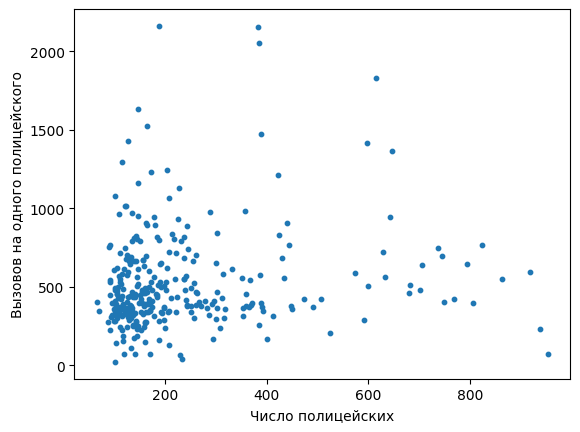

In [93]:
Crime_clean2 = (
    Crime.filter(
        (pl.col(" LemasSwornFT: number of sworn full time police officers (numeric - expected to be integer) ") < 1000)
    ))
plt.scatter(Crime_clean2[' LemasSwornFT: number of sworn full time police officers (numeric - expected to be integer) '], Crime_clean2[' PolicReqPerOffic: total requests for police per police officer (numeric - decimal) '], s=10)
plt.xlabel('Число полицейских')
plt.ylabel('Вызовов на одного полицейского')
plt.show()

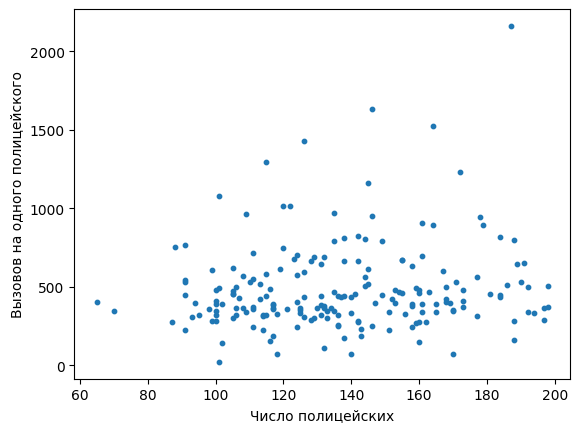

In [96]:
# В прошлый раз мы замечали закономерности на случаях до 200 сотрудников, также уберём выбрасы чтобы график стал наглядней
Crime_clean3 = (
    Crime.filter(
        (pl.col(" LemasSwornFT: number of sworn full time police officers (numeric - expected to be integer) ") < 200),
        (pl.col(" PolicReqPerOffic: total requests for police per police officer (numeric - decimal) ").quantile(0.9)) 
        #При проверке оказалось, что <200 итак поподают в квантиль, но эту строку я оставил
    ))
plt.scatter(Crime_clean3[' LemasSwornFT: number of sworn full time police officers (numeric - expected to be integer) '], Crime_clean3[' PolicReqPerOffic: total requests for police per police officer (numeric - decimal) '], s=10)
plt.xlabel('Число полицейских')
plt.ylabel('Вызовов на одного полицейского')
plt.show()

In [ ]:
# В описание датосета сказано что взяли несколько участков с меньше 100 человек, но данных недостаточно чтобы делать выводы.
# Для отрезка от 100 до 200 может тоже, чтобы указать скачки рядом 125 или 175 и т.д.
# Также если было бы больше данных, они могли бы перекрыть три 3 верхних и один нижний случай, которые не вписываются в картину уменьшения диапазонов.
# В целом данные на графике окола нуля надо рассмотреть на предмет графических и методических искажений, но и с ними картина в целом складывается.
# По более большому диапазону тоже видно, что чем меньше сотрудников, тем больше один человек может вытянуть работы.
# Однако здесь диапазон заполнен более равномерно и ситуация скорее касается выбросов. 
# Это может быть характерно для отрослей, которые меньше допускают недостаток людей.

In [ ]:
# Общие выводы:
# Подтвердилось отсутствие скрытых и неочевидных зависимостей.
# Относительно ожидаемые выводы о том, что от любого количества человек в пределах одного предприятия можно добиться равной производительности. 
# Однако есть разница в крайних не более 10% случаев - чем больше людей тем меньше производительность и наоборот.
# В определённых случаев видны более резкие скачки этих диапазонов около 30, 100, 200, 500 и т.д. Но они сильно зависят от специфики данных и отросли.